📌 Malignancy score: 1.0 → Binary label: 0


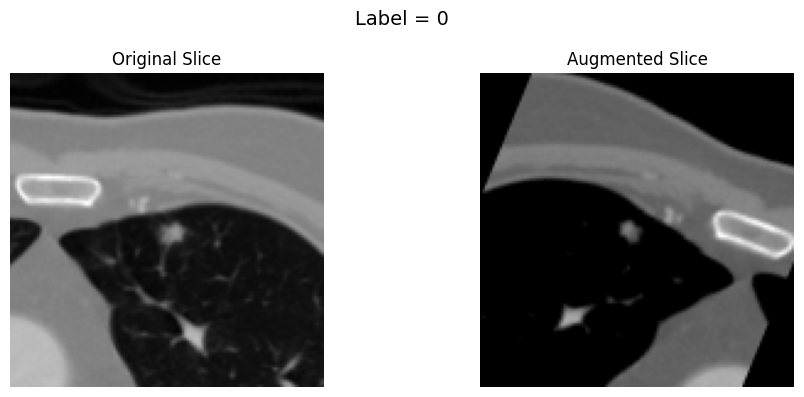

In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A

# 1. 경로 설정 (절대경로 사용)
image_path = "/data2/lijin/lidc-prep/LIDC-IDRI-slices/LIDC-IDRI-0003/nodule-2/images/slice-1.png"
csv_path = "/data2/lijin/lidc-prep/nodule_matched.csv"

# 2. 이미지 로드
assert os.path.exists(image_path), f"❗ 이미지 경로가 잘못됨: {image_path}"
img = Image.open(image_path).convert("L")           # 흑백 변환
img_np = np.array(img).astype(np.float32) / 255.0   # [0, 1] 정규화

# 3. 라벨 로딩
df = pd.read_csv(csv_path)
row = df[(df["patient_id"] == "LIDC-IDRI-0003") & (df["nodule_index"] == 2)].iloc[0]
malignancy_score = float(row["malignancy"])
binary_label = 1 if malignancy_score >= 3 else 0

print(f"📌 Malignancy score: {malignancy_score} → Binary label: {binary_label}")

# 4. 증강 파이프라인 정의
AUG = A.Compose([
    A.HorizontalFlip(p=1.0),
    A.RandomBrightnessContrast(p=1.0, brightness_limit=0.2, contrast_limit=0.2),
    A.Rotate(limit=30, p=1.0)
])

# 5. 증강 적용
aug_result = AUG(image=(img_np * 255).astype(np.uint8))['image'] / 255.0

# 6. 시각화
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(img_np, cmap='gray')
axs[0].set_title("Original Slice")
axs[1].imshow(aug_result, cmap='gray')
axs[1].set_title("Augmented Slice")
for ax in axs:
    ax.axis("off")
plt.suptitle(f"Label = {binary_label}", fontsize=14)
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


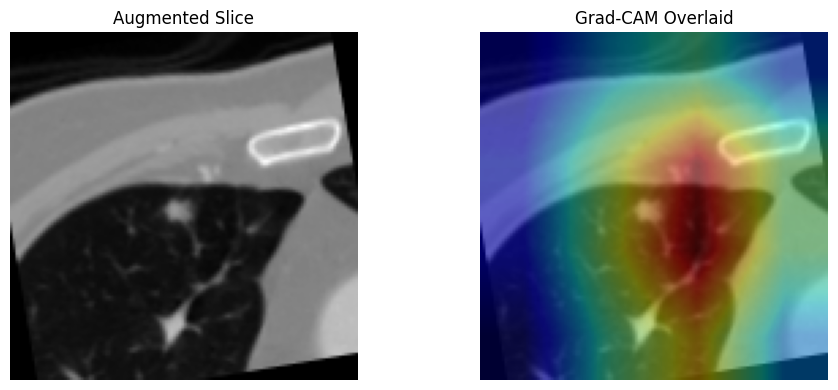

In [7]:
# label.ipynb 확장 버전: 증강 이미지 → 모델 입력 → Grad-CAM 시각화

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
import cv2
from torchvision.transforms.functional import to_tensor


# 1. 이미지 경로와 라벨 불러오기
image_path = "/data2/lijin/lidc-prep/LIDC-IDRI-slices/LIDC-IDRI-0003/nodule-2/images/slice-1.png"
csv_path = "/data2/lijin/lidc-prep/nodule_matched.csv"

img = Image.open(image_path).convert("L")
img_np = np.array(img).astype(np.float32) / 255.0

# 2. 라벨 매칭
df = pd.read_csv(csv_path)
row = df[(df["patient_id"] == "LIDC-IDRI-0003") & (df["nodule_index"] == 2)].iloc[0]
malignancy = float(row["malignancy"])
label = 1 if malignancy >= 3 else 0

# 3. 증강 적용
AUG = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
])
aug = AUG(image=(img_np * 255).astype(np.uint8))['image'] / 255.0

# 4. PyTorch Tensor 변환 (1, 1, H, W)
img_tensor = torch.tensor(aug).unsqueeze(0).unsqueeze(0).float()

# 5. 모델 준비 (ResNet18, 흑백 입력 → 첫 conv 수정)
resnet = models.resnet18(pretrained=True)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.eval()

# 6. Forward + Grad-CAM 준비
img_tensor.requires_grad_()
outputs = resnet(img_tensor)
preds = torch.sigmoid(outputs)
preds.max().backward()

# 7. Grad-CAM용 특성 맵 추출
def get_gradcam(model, feature_layer):
    fmap = None
    grad = None
    def forward_hook(module, input, output):
        nonlocal fmap
        fmap = output.detach()
    def backward_hook(module, grad_input, grad_output):
        nonlocal grad
        grad = grad_output[0].detach()

    handle_f = feature_layer.register_forward_hook(forward_hook)
    handle_b = feature_layer.register_backward_hook(backward_hook)
    model(img_tensor)
    model.zero_grad()
    output = model(img_tensor)
    output.max().backward()
    handle_f.remove()
    handle_b.remove()

    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = (weights * fmap).sum(dim=1).squeeze()
    cam = torch.relu(cam)
    cam -= cam.min()
    cam /= cam.max()
    return cam.cpu().numpy()

# cam: [H_cam, W_cam] (ex: 7x7) → 원본 이미지 크기로 업샘플
cam_resized = cv2.resize(cam, (aug.shape[1], aug.shape[0]))
cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())  # normalize

# 왼쪽: 증강된 슬라이스
# 오른쪽: 슬라이스 위에 Grad-CAM heatmap 덧입힘
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(aug, cmap='gray')
axs[0].set_title("Augmented Slice")
axs[0].axis("off")

axs[1].imshow(aug, cmap='gray')
axs[1].imshow(cam_resized, cmap='jet', alpha=0.4)  # 겹쳐서 표시
axs[1].set_title("Grad-CAM Overlaid")
axs[1].axis("off")

plt.tight_layout()
plt.show()

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 예시 데이터
y_true = [0, 1, 1, 0, 1]
y_pred_prob = [0.2, 0.9, 0.8, 0.3, 0.6]
y_pred = [1 if p > 0.5 else 0 for p in y_pred_prob]

# 평가
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))
print("AUC:", roc_auc_score(y_true, y_pred_prob))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
AUC: 1.0


In [20]:
# lung_nodule_dataset.py (df 직접 입력 지원 + HU Clipping 포함)

import os
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
import cv2

class LungNoduleSliceDataset(Dataset):
    def __init__(self, df=None, csv_path=None, image_root=None, transform=None, label_threshold=3.0, hu_clip=(-1000, 400), resize=(224, 224)):
        if df is not None:
            self.df = df.reset_index(drop=True)
        elif csv_path is not None:
            self.df = pd.read_csv(csv_path)
        else:
            raise ValueError("Either df or csv_path must be provided.")

        self.image_root = image_root
        self.transform = transform
        self.label_threshold = label_threshold
        self.hu_clip = hu_clip
        self.resize = resize

        if 'binary_label' not in self.df.columns:
            self.df['binary_label'] = (self.df['malignancy'] >= label_threshold).astype(int)

        self.samples = []
        for _, row in self.df.iterrows():
            pid = row['patient_id']
            nid = row['nodule_index']
            image_path = os.path.join(image_root, pid, f"nodule-{nid}", "images", "slice-1.png")
            if os.path.exists(image_path):
                self.samples.append((image_path, row['binary_label']))

    def __len__(self):
        return len(self.samples)

    def preprocess_slice(self, img_np):
        img_np = np.clip(img_np, self.hu_clip[0], self.hu_clip[1])
        img_np = (img_np - self.hu_clip[0]) / (self.hu_clip[1] - self.hu_clip[0])
        img_np = np.clip(img_np, 0.0, 1.0)
        img_np = cv2.resize(img_np, self.resize, interpolation=cv2.INTER_LINEAR)
        return img_np

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        img = Image.open(image_path).convert("L")
        img_np = np.array(img).astype(np.float32)
        img_np = self.preprocess_slice(img_np)

        if self.transform:
            img_np = self.transform(image=(img_np * 255).astype(np.uint8))['image'] / 255.0

        img_tensor = np.expand_dims(img_np, axis=0)  # [1, H, W]
        return img_tensor, label


if __name__ == "__main__":
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Rotate(limit=15, p=0.5),
    ])

    df = pd.read_csv("/data2/lijin/lidc-prep/nodule_matched.csv")
    df['binary_label'] = (df['malignancy'] >= 3.0).astype(int)

    dataset = LungNoduleSliceDataset(
        df=df,
        image_root="/data2/lijin/lidc-prep/LIDC-IDRI-slices",
        transform=transform
    )

    print(f"Total samples: {len(dataset)}")
    img, label = dataset[0]
    print("Sample shape:", img.shape, "Label:", label)

Total samples: 2549
Sample shape: (1, 224, 224) Label: 0


In [ ]:
# 학습 스크립트 수정본 (HU Clipping 포함 Dataset + ToTensor 전환 + 성능 저장 오류 수정)

from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
import albumentations as A
from lung_nodule_dataset import LungNoduleSliceDataset
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 하이퍼파라미터 설정
batch_size = 16
learning_rate = 1e-4
num_epochs = 5

# 커스텀 모델 정의
class LungCancerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(nn.Linear(num_features, 1), nn.Sigmoid())

    def forward(self, x):
        return self.base_model(x)
    


df = pd.read_csv(csv_path)
df['binary_label'] = (df['malignancy'] >= 3.0).astype(int)

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['binary_label'], random_state=42
)

# Dataset에 df 직접 넘기는 방식 추가 필요
train_dataset = LungNoduleSliceDataset(df=train_df, root='./data', train=True, download=True)
test_dataset = LungNoduleSliceDataset(df=test_df, root='./data', train=True, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("total samples:", len(train_dataset))

# 모델 구성
model = LungCancerClassifier().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 학습 및 평가 로그 저장 리스트
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
total_step = len(train_loader)

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    total = 0
    correct = 0
    total_loss = 0

    for i, (images, labels) in enumerate(train_loader):
        images = torch.tensor(images).to(device).float()
        labels = torch.tensor(labels).to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Train_Loss [{loss.item():.4f}], Accuracy [{(correct/total)*100:.2f}]')

    avg_train_loss = total_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    train_acc_list.append((correct / total) * 100)


    # 테스트 루프 후 추가
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device).float()
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            probs = outputs.detach().cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_preds.extend(preds.flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # 성능 지표 계산
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, probs)

    print(f"📊 F1-score: {f1:.4f}")
    print(f"📈 AUC: {auc:.4f}")

    # # 테스트 루프
    # correct = 0
    # test_loss = 0
    # total = 0
    # model.eval()

    # with torch.no_grad():
    #     for images, labels in test_loader:
    #         images = torch.tensor(images).to(device).float()
    #         labels = torch.tensor(labels).to(device).float().unsqueeze(1)

    #         outputs = model(images)
    #         loss = criterion(outputs, labels)

    #         test_loss += loss.item()
    #         predicted = (outputs > 0.5).float()
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()

    # avg_test_loss = test_loss / len(test_loader)
    # test_acc = (correct / total) * 100
    # test_loss_list.append(avg_test_loss)
    # test_acc_list.append(test_acc)

    # print(f'TEST Epoch [{epoch+1}/{num_epochs}], Loss [{avg_test_loss:.4f}], Accuracy [{test_acc:.2f}]')
    
    print("Test label 분포:", np.unique(all_labels, return_counts=True))
    print("Test 예측값 분포:", np.unique(all_preds, return_counts=True))

# 결과 시각화
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [2]:
# 임시 데이터 전용 코드 테스트 모드: 성능 자동 진단 포함

from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
import albumentations as A
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from lung_nodule_dataset import LungNoduleSliceDataset

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 하이퍼파라미터
batch_size = 16
learning_rate = 1e-4
num_epochs = 3

# 커스텀 모델
class LungCancerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(nn.Linear(num_features, 1), nn.Sigmoid())

    def forward(self, x):
        return self.base_model(x)

# 데이터 로드 및 라벨 확인
csv_path = "/data2/lijin/lidc-prep/nodule_matched.csv"
df = pd.read_csv(csv_path)
df['binary_label'] = df['malignancy'].astype(int)
print("✅ 전체 라벨 분포:")
print(df['binary_label'].value_counts())

# Stratified split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['binary_label'], random_state=42)
print("✅ 분할 후 라벨 분포:")
print("Train:", train_df['binary_label'].value_counts())
print("Test:", test_df['binary_label'].value_counts())

# 증강
a_train = A.Compose([A.HorizontalFlip(p=0.7), A.RandomBrightnessContrast(p=0.5), A.Rotate(limit=15, p=0.5)])
a_test = A.Compose([])

# Dataset
train_dataset = LungNoduleSliceDataset(df=train_df, image_root="/data2/lijin/lidc-prep/LIDC-IDRI-slices", transform=a_train)
test_dataset = LungNoduleSliceDataset(df=test_df, image_root="/data2/lijin/lidc-prep/LIDC-IDRI-slices", transform=a_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 세팅
model = LungCancerClassifier().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 훈련 + 평가 루프
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device).float()
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] Train Loss: {total_loss / len(train_loader):.4f}, Accuracy: {(correct/total)*100:.2f}%")

    # 평가
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    test_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device).float()
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            probs = outputs.cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_preds.extend(preds.flatten())
            all_probs.extend(probs.flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

            loss = criterion(outputs, labels)
            test_loss += loss.item()

    # 성능 지표 출력
    try:
        f1 = f1_score(all_labels, all_preds)
        auc = roc_auc_score(all_labels, all_probs)
        print(f"✅ [Epoch {epoch+1}] Test Loss: {test_loss / len(test_loader):.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    except ValueError as e:
        print("⚠️  지표 계산 실패:", str(e))

    print("📊 라벨 분포:", np.unique(all_labels, return_counts=True))
    print("📈 예측 분포:", np.unique(all_preds, return_counts=True))

cuda
✅ 전체 라벨 분포:
binary_label
0    1987
1     629
Name: count, dtype: int64
✅ 분할 후 라벨 분포:
Train: binary_label
0    1589
1     503
Name: count, dtype: int64
Test: binary_label
0    398
1    126
Name: count, dtype: int64


/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] Train Loss: 0.5916, Accuracy: 69.57%
✅ [Epoch 1] Test Loss: 0.5576, F1: 0.0839, AUC: 0.6754
📊 라벨 분포: (array([0., 1.], dtype=float32), array([382, 126]))
📈 예측 분포: (array([0, 1]), array([491,  17]))
[Epoch 2] Train Loss: 0.5040, Accuracy: 77.76%
✅ [Epoch 2] Test Loss: 0.5009, F1: 0.4425, AUC: 0.7511
📊 라벨 분포: (array([0., 1.], dtype=float32), array([382, 126]))
📈 예측 분포: (array([0, 1]), array([408, 100]))
[Epoch 3] Train Loss: 0.4611, Accuracy: 79.91%
✅ [Epoch 3] Test Loss: 0.4988, F1: 0.4000, AUC: 0.7527
📊 라벨 분포: (array([0., 1.], dtype=float32), array([382, 126]))
📈 예측 분포: (array([0, 1]), array([454,  54]))


In [3]:
print(df['malignancy'].describe())
print(df['malignancy'].value_counts())

count    2616.000000
mean        0.240443
std         0.427434
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: malignancy, dtype: float64
malignancy
0.0    1987
1.0     629
Name: count, dtype: int64


In [4]:
# 모델 실험 스크립트 (EfficientNet-B0 / DenseNet121 / ResNet34 / ResNet50)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import albumentations as A
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from lung_nodule_dataset import LungNoduleSliceDataset

# 하이퍼파라미터 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
learning_rate = 1e-4
num_epochs = 3

# 모델 로딩 함수
def get_model(name):
    if name == 'resnet34':
        base = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = base.fc.in_features
        base.fc = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())

    elif name == 'resnet50':
        base = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = base.fc.in_features
        base.fc = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())

    elif name == 'densenet121':
        base = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        base.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = base.classifier.in_features
        base.classifier = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())

    elif name == 'efficientnet_b0':
        base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        base.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        num_ftrs = base.classifier[1].in_features
        base.classifier = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())

    else:
        raise ValueError(f"Unsupported model: {name}")
    
    return base

# 데이터 로딩 및 전처리
csv_path = "/data2/lijin/lidc-prep/nodule_matched.csv"
df = pd.read_csv(csv_path)
df['binary_label'] = df['malignancy'].astype(int)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['binary_label'], random_state=42)

a_train = A.Compose([A.HorizontalFlip(p=0.7), A.RandomBrightnessContrast(p=0.5), A.Rotate(limit=15, p=0.5)])
a_test = A.Compose([])

train_dataset = LungNoduleSliceDataset(df=train_df, image_root="/data2/lijin/lidc-prep/LIDC-IDRI-slices", transform=a_train)
test_dataset = LungNoduleSliceDataset(df=test_df, image_root="/data2/lijin/lidc-prep/LIDC-IDRI-slices", transform=a_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 성능 기록
df_results = []

# 모델별 실험 반복
model_names = ['resnet34', 'resnet50', 'densenet121', 'efficientnet_b0']

for model_name in model_names:
    print(f"\n🚀 시작: {model_name}")
    model = get_model(model_name).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device).float()
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

        print(f"Epoch {epoch+1}: Train Loss: {total_loss / len(train_loader):.4f}, Accuracy: {(correct/total)*100:.2f}%")

    # 테스트 평가
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    test_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device).float()
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            probs = outputs.cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.extend(preds.flatten())
            all_probs.extend(probs.flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
            test_loss += criterion(outputs, labels).item()

    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    avg_test_loss = test_loss / len(test_loader)
    print(f"✅ {model_name}: Test Loss: {avg_test_loss:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    df_results.append({"model": model_name, "f1": f1, "auc": auc, "test_loss": avg_test_loss})

# 결과 출력
print("\n📊 모델별 결과 비교:")
df_results = pd.DataFrame(df_results)
print(df_results.sort_values(by="f1", ascending=False).reset_index(drop=True))


🚀 시작: resnet34
Epoch 1: Train Loss: 0.5638, Accuracy: 73.10%
Epoch 2: Train Loss: 0.5136, Accuracy: 77.32%
Epoch 3: Train Loss: 0.4675, Accuracy: 79.76%
✅ resnet34: Test Loss: 0.4978, F1: 0.5105, AUC: 0.7747

🚀 시작: resnet50
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/iujeong/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:08<00:00, 12.5MB/s]


Epoch 1: Train Loss: 0.5661, Accuracy: 74.72%
Epoch 2: Train Loss: 0.5347, Accuracy: 75.45%
Epoch 3: Train Loss: 0.5018, Accuracy: 78.20%
✅ resnet50: Test Loss: 0.4862, F1: 0.3874, AUC: 0.7517

🚀 시작: densenet121
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/iujeong/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:02<00:00, 13.9MB/s]


Epoch 1: Train Loss: 0.5598, Accuracy: 75.01%
Epoch 2: Train Loss: 0.5062, Accuracy: 76.78%
Epoch 3: Train Loss: 0.4762, Accuracy: 78.93%
✅ densenet121: Test Loss: 0.4673, F1: 0.4162, AUC: 0.7996

🚀 시작: efficientnet_b0
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/iujeong/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:02<00:00, 10.3MB/s]


Epoch 1: Train Loss: 0.5803, Accuracy: 73.05%
Epoch 2: Train Loss: 0.5400, Accuracy: 75.16%
Epoch 3: Train Loss: 0.5111, Accuracy: 76.34%
✅ efficientnet_b0: Test Loss: 0.5039, F1: 0.3646, AUC: 0.7309

📊 모델별 결과 비교:
             model        f1       auc  test_loss
0         resnet34  0.510460  0.774724   0.497804
1      densenet121  0.416185  0.799593   0.467284
2         resnet50  0.387435  0.751745   0.486165
3  efficientnet_b0  0.364641  0.730927   0.503899


In [6]:
# 모델 실험 + 결과 정리 양식 자동 저장 구조

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import albumentations as A
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from lung_nodule_dataset import LungNoduleSliceDataset
import os

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 하이퍼파라미터 설정
batch_size = 16
learning_rate = 1e-4
num_epochs = 3

# 모델 불러오기 함수
def get_model(name):
    if name == 'resnet34':
        m = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        m.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        m.fc = nn.Sequential(nn.Linear(m.fc.in_features, 1), nn.Sigmoid())
    elif name == 'resnet50':
        m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        m.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        m.fc = nn.Sequential(nn.Linear(m.fc.in_features, 1), nn.Sigmoid())
    elif name == 'densenet121':
        m = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        m.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        m.classifier = nn.Sequential(nn.Linear(m.classifier.in_features, 1), nn.Sigmoid())
    elif name == 'efficientnet_b0':
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        m.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        m.classifier = nn.Sequential(nn.Linear(m.classifier[1].in_features, 1), nn.Sigmoid())
    else:
        raise ValueError(f"Unknown model: {name}")
    return m

# 데이터 로드 및 분할
csv_path = "/data2/lijin/lidc-prep/nodule_matched.csv"
df = pd.read_csv(csv_path)
df['binary_label'] = df['malignancy'].astype(int)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['binary_label'], random_state=42)

# 전처리
aug_train = A.Compose([A.HorizontalFlip(p=0.7), A.RandomBrightnessContrast(p=0.5), A.Rotate(limit=15, p=0.5)])
aug_test = A.Compose([])

train_dataset = LungNoduleSliceDataset(df=train_df, image_root="/data2/lijin/lidc-prep/LIDC-IDRI-slices", transform=aug_train)
test_dataset = LungNoduleSliceDataset(df=test_df, image_root="/data2/lijin/lidc-prep/LIDC-IDRI-slices", transform=aug_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 결과 기록 리스트
all_results = []

# 실험할 모델들
models_to_test = ['resnet34', 'resnet50', 'densenet121', 'efficientnet_b0']

for model_name in models_to_test:
    print(f"\n🔍 실험 시작: {model_name}")
    model = get_model(model_name).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    best_f1 = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device).float()
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            train_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {train_loss/len(train_loader):.4f} | Acc {(correct/total)*100:.2f}%")

    # 평가
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    test_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device).float()
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            probs = outputs.cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_preds.extend(preds.flatten())
            all_probs.extend(probs.flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

            loss = criterion(outputs, labels)
            test_loss += loss.item()

    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    test_loss /= len(test_loader)

    result = {
        "model": model_name,
        "f1": round(f1, 4),
        "auc": round(auc, 4),
        "test_loss": round(test_loss, 4),
        "note": "epoch=3, batch=16, lr=1e-4"
    }
    all_results.append(result)
    print(f"✅ 결과: {result}")

# 결과 저장 및 출력
results_df = pd.DataFrame(all_results)
results_df.to_csv("model_comparison_results.csv", index=False)
print("\n📊 전체 결과 정리표:")
print(results_df.sort_values(by="f1", ascending=False).reset_index(drop=True))

# 학습 루프 마지막에서
torch.save(model.state_dict(), f"best_model_{model_name}.pth")



🔍 실험 시작: resnet34
Epoch 1: Loss 0.5906 | Acc 71.78%
Epoch 2: Loss 0.5023 | Acc 78.25%
Epoch 3: Loss 0.4688 | Acc 79.57%
✅ 결과: {'model': 'resnet34', 'f1': 0.031, 'auc': np.float64(0.7462), 'test_loss': 0.5506, 'note': 'epoch=3, batch=16, lr=1e-4'}

🔍 실험 시작: resnet50
Epoch 1: Loss 0.5757 | Acc 74.57%
Epoch 2: Loss 0.5437 | Acc 75.11%
Epoch 3: Loss 0.5313 | Acc 75.21%
✅ 결과: {'model': 'resnet50', 'f1': 0.0, 'auc': np.float64(0.6556), 'test_loss': 0.536, 'note': 'epoch=3, batch=16, lr=1e-4'}

🔍 실험 시작: densenet121
Epoch 1: Loss 0.5924 | Acc 69.48%
Epoch 2: Loss 0.5243 | Acc 76.73%
Epoch 3: Loss 0.4899 | Acc 78.59%
✅ 결과: {'model': 'densenet121', 'f1': 0.4278, 'auc': np.float64(0.7323), 'test_loss': 0.4988, 'note': 'epoch=3, batch=16, lr=1e-4'}

🔍 실험 시작: efficientnet_b0
Epoch 1: Loss 0.5810 | Acc 74.28%
Epoch 2: Loss 0.5381 | Acc 74.72%
Epoch 3: Loss 0.5308 | Acc 76.53%
✅ 결과: {'model': 'efficientnet_b0', 'f1': 0.1644, 'auc': np.float64(0.6792), 'test_loss': 0.5232, 'note': 'epoch=3, batch=16,

In [4]:
with open("/data1/lidc-idri/nodule_malignancy_scores.json") as f:
    data = json.load(f)

# 가장 처음 key와 내부 구조 출력
for k, v in data.items():
    print("Key:", k)
    print("Value:", v)
    break

Key: LIDC-IDRI-0173
Value: {'slice_62': {'reader_3': [{'noduleID': 'Nodule 001', 'score': 2, 'polygon': [[62, 261], [61, 261], [60, 262], [61, 263], [62, 263], [62, 263], [63, 263], [64, 263], [65, 263], [65, 262], [65, 261], [65, 261], [64, 261], [63, 261], [62, 261], [62, 261]]}]}, 'slice_63': {'reader_3': [{'noduleID': 'Nodule 001', 'score': 2, 'polygon': [[60, 260], [59, 261], [59, 261], [59, 262], [59, 263], [59, 263], [60, 263], [61, 264], [62, 265], [62, 265], [63, 266], [64, 265], [65, 264], [65, 263], [65, 263], [65, 262], [64, 261], [63, 261], [62, 261], [62, 260], [61, 260], [60, 260]]}]}, 'slice_64': {'reader_3': [{'noduleID': 'Nodule 001', 'score': 2, 'polygon': [[61, 261], [60, 261], [59, 262], [59, 263], [59, 263], [59, 264], [59, 265], [60, 266], [61, 266], [62, 266], [62, 266], [63, 266], [64, 266], [65, 265], [65, 264], [65, 263], [65, 263], [65, 262], [65, 261], [64, 261], [63, 261], [62, 261], [62, 261], [61, 261]]}]}}


In [1]:
# 모델 실험 스크립트 (EfficientNet-B0 / DenseNet121 / ResNet34 / ResNet50)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import albumentations as A
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from lung_nodule_dataset import LungNoduleSliceDataset  # 이 클래스는 npy 불러오게 정의되어 있어야 함
import json
import cv2

# 하이퍼파라미터 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
learning_rate = 1e-4
num_epochs = 3

# 모델 로딩 함수
def get_model(name):
    if name == 'resnet34':
        base = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = base.fc.in_features
        base.fc = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())

    elif name == 'resnet50':
        base = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = base.fc.in_features
        base.fc = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())

    elif name == 'densenet121':
        base = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        base.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = base.classifier.in_features
        base.classifier = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())

    elif name == 'efficientnet_b0':
        base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        base.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        num_ftrs = base.classifier[1].in_features
        base.classifier = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())

    else:
        raise ValueError(f"Unsupported model: {name}")
    
    return base

# JSON 기반 메타데이터 로딩 (각 npy 경로와 score 포함)
with open("/data1/lidc-idri/nodule_malignancy_scores.json") as f:
    raw = json.load(f)

records = []

for subj_id, slice_dict in raw.items():
    for slice_key, reader_dict in slice_dict.items():
        slice_idx = int(slice_key.replace("slice_", ""))
        for reader, annotations in reader_dict.items():
            for ann in annotations:
                record = {
                    "subject_id": subj_id,
                    "slice": slice_idx,
                    "reader": reader,
                    "score": ann["score"],
                    "polygon": ann["polygon"],
                    "image_path": f"{subj_id}/slice_{slice_idx:03d}_2.npy"
                }
                records.append(record)

df = pd.DataFrame(records)
df['binary_label'] = (df['score'] >= 3).astype(int)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['binary_label'], random_state=42)

# 증강 정의
a_train = A.Compose([A.HorizontalFlip(p=0.7), A.RandomBrightnessContrast(p=0.5), A.Rotate(limit=15, p=0.5)])
a_test = A.Compose([])

# npy 슬라이스 기반 Dataset 사용
data_root = "/data1/lidc-idri/slices"

train_dataset = LungNoduleSliceDataset(df=train_df, image_root=data_root, transform=a_train)
test_dataset = LungNoduleSliceDataset(df=test_df, image_root=data_root, transform=a_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 성능 기록
df_results = []

model_names = ['resnet34', 'resnet50', 'densenet121', 'efficientnet_b0']

for model_name in model_names:
    print(f"\n🚀 시작: {model_name}")
    model = get_model(model_name).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device).float()
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

        print(f"Epoch {epoch+1}: Train Loss: {total_loss / len(train_loader):.4f}, Accuracy: {(correct/total)*100:.2f}%")

    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    test_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device).float()
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            probs = outputs.cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.extend(preds.flatten())
            all_probs.extend(probs.flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
            test_loss += criterion(outputs, labels).item()

    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    avg_test_loss = test_loss / len(test_loader)
    print(f"✅ {model_name}: Test Loss: {avg_test_loss:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    df_results.append({"model": model_name, "f1": f1, "auc": auc, "test_loss": avg_test_loss})

print("\n📊 모델별 결과 비교:")
df_results = pd.DataFrame(df_results)
print(df_results.sort_values(by="f1", ascending=False).reset_index(drop=True))


🚀 시작: resnet34
Epoch 1: Train Loss: 0.4091, Accuracy: 85.71%
Epoch 2: Train Loss: 0.4076, Accuracy: 86.88%
Epoch 3: Train Loss: 0.3809, Accuracy: 87.42%
✅ resnet34: Test Loss: 12.3504, F1: 0.0000, AUC: 0.4675

🚀 시작: resnet50
Epoch 1: Train Loss: 0.4155, Accuracy: 86.30%
Epoch 2: Train Loss: 0.4019, Accuracy: 86.76%
Epoch 3: Train Loss: 0.3734, Accuracy: 86.88%
✅ resnet50: Test Loss: 13.6261, F1: 0.0000, AUC: 0.5000

🚀 시작: densenet121
Epoch 1: Train Loss: 0.4263, Accuracy: 83.47%
Epoch 2: Train Loss: 0.3751, Accuracy: 86.92%
Epoch 3: Train Loss: 0.3765, Accuracy: 86.96%
✅ densenet121: Test Loss: 13.6261, F1: 0.0000, AUC: 0.5000

🚀 시작: efficientnet_b0
Epoch 1: Train Loss: 0.4597, Accuracy: 82.01%
Epoch 2: Train Loss: 0.3793, Accuracy: 86.96%
Epoch 3: Train Loss: 0.3749, Accuracy: 86.88%
✅ efficientnet_b0: Test Loss: 13.6261, F1: 0.0000, AUC: 0.5000

📊 모델별 결과 비교:
             model   f1       auc  test_loss
0         resnet34  0.0  0.467538  12.350431
1         resnet50  0.0  0.500000  1

In [ ]:
# 모델 실험 스크립트 (Regression - malignancy score 예측)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import albumentations as A
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from lung_nodule_dataset import LungNoduleSliceDataset
import json
import cv2

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 하이퍼파라미터 설정
batch_size = 16
learning_rate = 1e-4
num_epochs = 3

# 모델 로딩 함수 (Sigmoid 제거)
def get_model(name):
    if name == 'resnet34':
        base = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = base.fc.in_features
        base.fc = nn.Linear(num_ftrs, 1)

    elif name == 'resnet50':
        base = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = base.fc.in_features
        base.fc = nn.Linear(num_ftrs, 1)

    elif name == 'densenet121':
        base = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        base.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = base.classifier.in_features
        base.classifier = nn.Linear(num_ftrs, 1)

    elif name == 'efficientnet_b0':
        base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        base.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        num_ftrs = base.classifier[1].in_features
        base.classifier = nn.Linear(num_ftrs, 1)

    else:
        raise ValueError(f"Unsupported model: {name}")
    
    return base

# JSON 데이터 로딩
with open("/data1/lidc-idri/nodule_malignancy_scores.json") as f:
    raw = json.load(f)

records = []
for subj_id, slice_dict in raw.items():
    for slice_key, reader_dict in slice_dict.items():
        slice_idx = int(slice_key.replace("slice_", ""))
        for reader, annotations in reader_dict.items():
            for ann in annotations:
                records.append({
                    "subject_id": subj_id,
                    "slice": slice_idx,
                    "reader": reader,
                    "score": ann["score"],
                    "polygon": ann["polygon"],
                    "image_path": f"{subj_id}/slice_{slice_idx:03d}_2.npy"
                })

df = pd.DataFrame(records)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

a_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.GaussNoise(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
])
a_test = A.Compose([])

data_root = "/data1/lidc-idri/slices"
train_dataset = LungNoduleSliceDataset(df=train_df, image_root=data_root, transform=a_train)
test_dataset = LungNoduleSliceDataset(df=test_df, image_root=data_root, transform=a_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 회귀 결과 저장용
df_results = []
model_names = ['resnet34', 'resnet50', 'densenet121', 'efficientnet_b0']

train_loss_list = []
train_acc_list = []

test_loss_list = []
test_acc_list = []

total_step = len(train_loader)

for model_name in model_names:
    print(f"\n🚀 시작: {model_name}")
    model = get_model(model_name).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        
        correct = 0
        total = 0
        epoch_loss = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device).float()
            labels = torch.tensor(labels).unsqueeze(1).float().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            epoch_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Train_Loss [{loss.item():.4f}], Accuracy [{(correct/total)*100:.2f}]')

    train_loss = epoch_loss / total_step
    train_acc = (correct / total) * 100

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    
    correct = 0
    test_loss = 0.0
    total = 0

    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device).float()
            labels = torch.tensor(labels).unsqueeze(1).float().to(device)
            outputs = model(images)
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
            test_loss += criterion(outputs, labels).item()

    mae = mean_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)
    mse = mean_squared_error(all_labels, all_preds)
    rmse = mse ** 0.5

    print(f"✅ {model_name}: RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    df_results.append({"model": model_name, "rmse": rmse, "mae": mae, "r2": r2, "loss": test_loss / len(test_loader)})

print("\n📊 회귀 결과 비교:")
df_results = pd.DataFrame(df_results)
print(df_results.sort_values(by="rmse").reset_index(drop=True))


cuda


/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



🚀 시작: resnet34


/tmp/ipykernel_2714787/316223514.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).unsqueeze(1).float().to(device)


Epoch [3/3], Train Loss: -30.7206, Train Accuracy: 0.00%


/tmp/ipykernel_2714787/316223514.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).unsqueeze(1).float().to(device)


✅ resnet34: RMSE: 2600.3826, MAE: 2486.1300, R²: -11690683.9295

🚀 시작: resnet50


/tmp/ipykernel_2714787/316223514.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).unsqueeze(1).float().to(device)


Epoch [3/3], Train Loss: -137.4636, Train Accuracy: 0.00%


/tmp/ipykernel_2714787/316223514.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).unsqueeze(1).float().to(device)


✅ resnet50: RMSE: 53361.3994, MAE: 52556.8367, R²: -4922887069.8113

🚀 시작: densenet121


/tmp/ipykernel_2714787/316223514.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).unsqueeze(1).float().to(device)


Epoch [3/3], Train Loss: -27.1709, Train Accuracy: 0.00%


/tmp/ipykernel_2714787/316223514.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).unsqueeze(1).float().to(device)


✅ densenet121: RMSE: 2518.3290, MAE: 2416.8392, R²: -10964537.9687

🚀 시작: efficientnet_b0


/tmp/ipykernel_2714787/316223514.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).unsqueeze(1).float().to(device)


Epoch [3/3], Train Loss: -29.4012, Train Accuracy: 0.00%


/tmp/ipykernel_2714787/316223514.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).unsqueeze(1).float().to(device)


✅ efficientnet_b0: RMSE: 165975.8464, MAE: 80310.1854, R²: -47627220500.0712

📊 회귀 결과 비교:
             model           rmse           mae            r2          loss
0      densenet121    2518.328968   2416.839217 -1.096454e+07  -2699.696362
1         resnet34    2600.382601   2486.129993 -1.169068e+07  -2784.871559
2         resnet50   53361.399369  52556.836707 -4.922887e+09 -57835.642209
3  efficientnet_b0  165975.846397  80310.185399 -4.762722e+10 -55940.182617


In [ ]:
# 1. 필요한 라이브러리
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import cv2
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torchvision.models as models
from tqdm import tqdm
from torch.utils.data import WeightedRandomSampler

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 하이퍼파라미터 설정
num_epochs = 20
learning_rate = 1e-3
batch_size = 16


# 2. 데이터셋 정의
class LungNoduleSliceDataset(Dataset):
    def __init__(self, df, image_root, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_root = image_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_root, row['image_path'])
        label = row['label']
        img = np.load(img_path).astype(np.float32)
        img = cv2.resize(img, (224, 224))
        if self.transform:
            img = self.transform(image=(img * 255).astype(np.uint8))['image'] / 255.0
        if img.ndim == 2:
            img = np.expand_dims(img, axis=0)
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# 3. 데이터 준비
df = pd.read_csv("/home/iujeong/lung_cancer/lidc_nodule_info.csv")
df = df[df['score'] != 3].copy()
df['label'] = df['score'].apply(lambda x: 1 if x >= 4 else 0)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

image_root = "/data1/lidc-idri/slices"

a_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
])
a_test = A.Compose([])

train_dataset = LungNoduleSliceDataset(train_df, image_root, transform=a_train)
test_dataset = LungNoduleSliceDataset(test_df, image_root, transform=a_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. 모델 정의
def get_binary_model():
    model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model

# 5. 학습 및 평가

model = get_binary_model().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = (torch.sigmoid(outputs) > 0.3).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    acc = correct / total
    print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_loader):.4f} | Accuracy: {acc:.4f}")

# 6. 테스트 평가
model.eval()
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.unsqueeze(1).to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_preds.extend(preds.cpu().numpy().flatten())
        all_probs.extend(probs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

print(f"\n✅ Test Accuracy: {acc:.4f} | F1 Score: {f1:.4f} | AUC: {auc:.4f}")

cuda


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Epoch 1 | Loss: 0.4665 | Accuracy: 0.9005


100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


Epoch 2 | Loss: 0.4253 | Accuracy: 0.9232


100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


Epoch 3 | Loss: 0.3947 | Accuracy: 0.9559


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


Epoch 4 | Loss: 0.4460 | Accuracy: 0.9383


100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


Epoch 5 | Loss: 0.4079 | Accuracy: 0.9509


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


Epoch 6 | Loss: 0.4155 | Accuracy: 0.9433


100%|██████████| 50/50 [00:17<00:00,  2.78it/s]


Epoch 7 | Loss: 0.4025 | Accuracy: 0.9433


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]


Epoch 8 | Loss: 0.4014 | Accuracy: 0.9458


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


Epoch 9 | Loss: 0.4017 | Accuracy: 0.9509


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Epoch 10 | Loss: 0.4050 | Accuracy: 0.9408


100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


Epoch 11 | Loss: 0.3991 | Accuracy: 0.9584


100%|██████████| 50/50 [00:14<00:00,  3.38it/s]


Epoch 12 | Loss: 0.4138 | Accuracy: 0.9496


100%|██████████| 50/50 [00:14<00:00,  3.42it/s]


Epoch 13 | Loss: 0.4087 | Accuracy: 0.9370


100%|██████████| 50/50 [00:15<00:00,  3.28it/s]


Epoch 14 | Loss: 0.4302 | Accuracy: 0.9408


100%|██████████| 50/50 [00:12<00:00,  3.90it/s]


Epoch 15 | Loss: 0.4095 | Accuracy: 0.9534


100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


Epoch 16 | Loss: 0.3909 | Accuracy: 0.9584


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]


Epoch 17 | Loss: 0.4283 | Accuracy: 0.9408


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Epoch 18 | Loss: 0.3908 | Accuracy: 0.9358


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


Epoch 19 | Loss: 0.3768 | Accuracy: 0.9584


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Epoch 20 | Loss: 0.4130 | Accuracy: 0.9446


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


✅ Test Accuracy: 0.9246 | F1 Score: 0.0000 | AUC: 0.5000


In [13]:
from torch.utils.data import WeightedRandomSampler

# 1. 클래스별 샘플 수 계산
class_sample_count = train_df['label'].value_counts().to_dict()
weights = train_df['label'].map(lambda x: 1.0 / class_sample_count[x]).values
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

# 2. DataLoader 수정 (샘플러 적용)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. 모델, 손실 함수
model = get_binary_model().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([4.4]).to(device))  # pos_weight ↑
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 4. 학습 루프
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = (torch.sigmoid(outputs) > 0.2).float()  # ✅ threshold 낮춤
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    acc = correct / total
    print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_loader):.4f} | Accuracy: {acc:.4f}")

# 5. 테스트 평가
model.eval()
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.unsqueeze(1).to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()  # ✅ threshold 낮춤

        all_preds.extend(preds.cpu().numpy().flatten())
        all_probs.extend(probs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

# 6. 성능 지표
from sklearn.metrics import classification_report

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

print(f"\n✅ Test Accuracy: {acc:.4f} | F1 Score: {f1:.4f} | AUC: {auc:.4f}")
print("\n🔍 Classification Report:\n", classification_report(all_labels, all_preds))

100%|██████████| 50/50 [00:02<00:00, 19.92it/s]


Epoch 1 | Loss: 1.6879 | Accuracy: 0.5076


100%|██████████| 50/50 [00:02<00:00, 19.94it/s]


Epoch 2 | Loss: 1.3294 | Accuracy: 0.4874


100%|██████████| 50/50 [00:02<00:00, 20.65it/s]


Epoch 3 | Loss: 1.3779 | Accuracy: 0.4836


100%|██████████| 50/50 [00:02<00:00, 19.89it/s]


Epoch 4 | Loss: 1.3202 | Accuracy: 0.5076


100%|██████████| 50/50 [00:02<00:00, 21.06it/s]


Epoch 5 | Loss: 1.3107 | Accuracy: 0.4836


100%|██████████| 50/50 [00:02<00:00, 20.70it/s]


Epoch 6 | Loss: 1.2879 | Accuracy: 0.5126


100%|██████████| 50/50 [00:02<00:00, 20.05it/s]


Epoch 7 | Loss: 1.3201 | Accuracy: 0.4899


100%|██████████| 50/50 [00:02<00:00, 20.17it/s]


Epoch 8 | Loss: 1.2885 | Accuracy: 0.5000


100%|██████████| 50/50 [00:02<00:00, 19.74it/s]


Epoch 9 | Loss: 1.2843 | Accuracy: 0.5189


100%|██████████| 50/50 [00:02<00:00, 20.02it/s]


Epoch 10 | Loss: 1.3007 | Accuracy: 0.4924


100%|██████████| 50/50 [00:02<00:00, 20.44it/s]


Epoch 11 | Loss: 1.2959 | Accuracy: 0.5076


100%|██████████| 50/50 [00:02<00:00, 20.43it/s]


Epoch 12 | Loss: 1.3016 | Accuracy: 0.4937


100%|██████████| 50/50 [00:02<00:00, 19.87it/s]


Epoch 13 | Loss: 1.3026 | Accuracy: 0.4975


100%|██████████| 50/50 [00:02<00:00, 20.33it/s]


Epoch 14 | Loss: 1.3118 | Accuracy: 0.4950


100%|██████████| 50/50 [00:02<00:00, 20.06it/s]


Epoch 15 | Loss: 1.3019 | Accuracy: 0.5038


100%|██████████| 50/50 [00:02<00:00, 20.64it/s]


Epoch 16 | Loss: 1.2758 | Accuracy: 0.5252


100%|██████████| 50/50 [00:02<00:00, 19.30it/s]


Epoch 17 | Loss: 1.3098 | Accuracy: 0.5000


100%|██████████| 50/50 [00:02<00:00, 19.97it/s]


Epoch 18 | Loss: 1.2876 | Accuracy: 0.5101


100%|██████████| 50/50 [00:02<00:00, 20.99it/s]


Epoch 19 | Loss: 1.2947 | Accuracy: 0.5214


100%|██████████| 50/50 [00:02<00:00, 20.01it/s]


Epoch 20 | Loss: 1.2667 | Accuracy: 0.5227


100%|██████████| 13/13 [00:00<00:00, 71.36it/s]


✅ Test Accuracy: 0.0754 | F1 Score: 0.1402 | AUC: 0.5000

🔍 Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       184
         1.0       0.08      1.00      0.14        15

    accuracy                           0.08       199
   macro avg       0.04      0.50      0.07       199
weighted avg       0.01      0.08      0.01       199




/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

In [14]:
# 원본 분포 확인
print("Before Oversampling:")
print(train_df['label'].value_counts())

# 악성 샘플(1) 오버샘플링
df_pos = train_df[train_df['label'] == 1]
df_neg = train_df[train_df['label'] == 0]

# label=1을 label=0만큼 복제
df_pos_upsampled = df_pos.sample(n=len(df_neg), replace=True, random_state=42)

# 데이터 결합 및 셔플
train_df_balanced = pd.concat([df_neg, df_pos_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# 오버샘플링 후 확인
print("\nAfter Oversampling:")
print(train_df_balanced['label'].value_counts())

Before Oversampling:
label
0    761
1     33
Name: count, dtype: int64

After Oversampling:
label
0    761
1    761
Name: count, dtype: int64


In [28]:
import os
import pandas as pd

# CSV 로드
csv_path = "/home/iujeong/lung_cancer/lidc_nodule_info.csv"
df = pd.read_csv(csv_path)

# score → label 변환
df = df[df['score'] != 3].copy()
df['label'] = df['score'].apply(lambda x: 1 if x >= 4 else 0)

# 이미지 루트 경로
image_root = "/data1/lidc-idri/slices"

# 실제 존재하는 파일만 필터링
def check_file_exists(row):
    full_path = os.path.join(image_root, row['image_path'])
    return os.path.exists(full_path)

df['exists'] = df.apply(check_file_exists, axis=1)
df_valid = df[df['exists'] == True]

# 레이블 분포 출력
print("✅ 전체 레이블 분포 (존재하는 파일만):")
print(df_valid['label'].value_counts())

✅ 전체 레이블 분포 (존재하는 파일만):
label
0    945
1     48
Name: count, dtype: int64


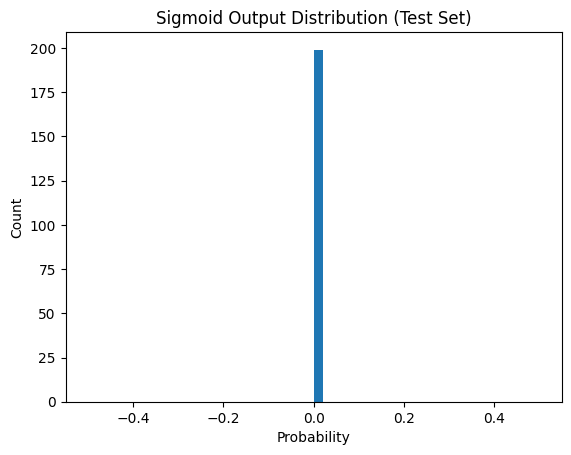

In [6]:
import matplotlib.pyplot as plt
plt.hist(all_probs, bins=50)
plt.title("Sigmoid Output Distribution (Test Set)")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

In [2]:
# 예측 분포 확인
print("Predicted probabilities:", all_probs[:20])
print("Predicted labels:", np.unique(all_preds, return_counts=True))
print("True labels:", np.unique(all_labels, return_counts=True))

Predicted probabilities: [np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0)]
Predicted labels: (array([0.], dtype=float32), array([199]))
True labels: (array([0., 1.], dtype=float32), array([184,  15]))


In [11]:
import json
import pandas as pd
import os

# 1. 경로 설정
json_path = "/data1/lidc-idri/nodule_malignancy_scores.json"
output_csv_path = "/home/iujeong/lung_cancer/lidc_nodule_info.csv"
image_root = "/data1/lidc-idri/slices"

# 2. JSON 로드
with open(json_path, "r") as f:
    data = json.load(f)

records = []

# 3. 파싱
for subj_id, slice_dict in data.items():
    for slice_key, reader_dict in slice_dict.items():
        slice_idx = int(slice_key.replace("slice_", ""))
        
        scores = []
        for reader, anns in reader_dict.items():
            for ann in anns:
                score = ann.get("score")
                if score is not None:
                    scores.append(score)

        if scores:
            score = max(scores)
            if score == 3:
                continue
            label = 1 if score >= 4 else 0

            image_path = f"{subj_id}/slice_{slice_idx:03d}_2.npy"
            full_path = os.path.join(image_root, image_path)
            if os.path.exists(full_path):
                records.append({
                    "subject_id": subj_id,
                    "slice": slice_idx,
                    "score": score,
                    "label": label,
                    "image_path": image_path
                })

# 4. DataFrame으로 저장
df = pd.DataFrame(records)
df.to_csv(output_csv_path, index=False)

print(f"✅ CSV 생성 완료: {output_csv_path}")
print(f"총 유효 데이터 수: {len(df)}개")

✅ CSV 생성 완료: /home/iujeong/lung_cancer/lidc_nodule_info.csv
총 유효 데이터 수: 993개


In [3]:
import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
import torch.nn.functional as F

# --- 설정 ---
SLICE_ROOT = "/data1/lidc-idri/slices"
BATCH_SIZE = 32
NUM_EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 파일 리스트 수집 ---
file_list = glob(os.path.join(SLICE_ROOT, "LIDC-IDRI-*", "*.npy"))

# --- score 3 제외, binary label 생성 ---
def extract_label_from_filename(filename):
    try:
        score = int(filename.split("_")[-1].replace(".npy", ""))
        if score == 3:
            return None
        return 1 if score >= 4 else 0
    except:
        return None

filtered_files = []
labels = []

for file in file_list:
    label = extract_label_from_filename(file)
    if label is not None:
        filtered_files.append(file)
        labels.append(label)

# --- train/val 분리 ---
train_files, val_files, train_labels, val_labels = train_test_split(
    filtered_files, labels, test_size=0.2, random_state=42
)

# --- 데이터셋 정의 ---
class LIDCDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        img = np.load(file_path).astype(np.float32)

        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = np.expand_dims(img, axis=0)  # (1, H, W)

        img_tensor = torch.tensor(img)

        # 강제 리사이즈 (224x224)
        img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

        return img_tensor, torch.tensor(label).float()

# --- Transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet input
])

train_dataset = LIDCDataset(train_files, train_labels)
val_dataset = LIDCDataset(val_files, val_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# --- 모델 ---
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# --- 학습 루프 ---
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(DEVICE), labels.unsqueeze(1).to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] Loss: {total_loss/len(train_loader):.4f}")

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).squeeze().long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")

Epoch 1/10: 100%|██████████| 134/134 [00:43<00:00,  3.09it/s]


[Epoch 1] Loss: 0.5816
Validation Accuracy: 0.7273


Epoch 2/10: 100%|██████████| 134/134 [00:04<00:00, 27.59it/s]


[Epoch 2] Loss: 0.3814
Validation Accuracy: 0.8238


Epoch 3/10: 100%|██████████| 134/134 [00:04<00:00, 27.89it/s]


[Epoch 3] Loss: 0.2383
Validation Accuracy: 0.8266


Epoch 4/10: 100%|██████████| 134/134 [00:04<00:00, 27.77it/s]


[Epoch 4] Loss: 0.1626
Validation Accuracy: 0.8641


Epoch 5/10: 100%|██████████| 134/134 [00:04<00:00, 28.10it/s]


[Epoch 5] Loss: 0.1256
Validation Accuracy: 0.8491


Epoch 6/10: 100%|██████████| 134/134 [00:04<00:00, 28.31it/s]


[Epoch 6] Loss: 0.0920
Validation Accuracy: 0.8172


Epoch 7/10: 100%|██████████| 134/134 [00:04<00:00, 28.23it/s]


[Epoch 7] Loss: 0.0509
Validation Accuracy: 0.8828


Epoch 8/10: 100%|██████████| 134/134 [00:04<00:00, 27.80it/s]


[Epoch 8] Loss: 0.0443
Validation Accuracy: 0.7666


Epoch 9/10: 100%|██████████| 134/134 [00:04<00:00, 28.28it/s]


[Epoch 9] Loss: 0.0752
Validation Accuracy: 0.8679


Epoch 10/10: 100%|██████████| 134/134 [00:04<00:00, 27.93it/s]


[Epoch 10] Loss: 0.0571
Validation Accuracy: 0.8810


In [8]:
# ResNet18 

import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F

from tqdm import tqdm

# --- 설정 ---
SLICE_ROOT = "/data1/lidc-idri/slices"
BATCH_SIZE = 16
NUM_EPOCHS = 100
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 파일 리스트 및 라벨 생성 ---
def extract_label_from_filename(filename):
    try:
        score = int(filename.split("_")[-1].replace(".npy", ""))
        if score == 3:
            return None
        return 1 if score >= 4 else 0
    except:
        return None

all_files = glob(os.path.join(SLICE_ROOT, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]

files, labels = zip(*file_label_pairs)
train_files, val_files, train_labels, val_labels = train_test_split(
    files, labels, test_size=0.2, random_state=42
)

# --- Transform ---
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# --- Dataset 정의 ---
class LIDCDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        img = np.load(file_path).astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = np.expand_dims(img, axis=0)  # (1, H, W)
        img_tensor = torch.tensor(img)

        # Resize to (1, 224, 224)
        img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, torch.tensor(label).float()

# --- DataLoader ---
train_dataset = LIDCDataset(train_files, train_labels, transform=train_transform)
val_dataset = LIDCDataset(val_files, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# --- 모델 정의 ---
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# --- 학습 루프 ---
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images = images.to(DEVICE)
        labels = labels.unsqueeze(1).to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] Loss: {total_loss/len(train_loader):.4f}")

    # --- 검증 ---
    model.eval()
    correct = total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).squeeze().long()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Validation Accuracy: {(acc)*100:.4f}")

    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), "best_model_resnet18.pth")
        print("✅ Best model saved!")

# --- 리포트 출력 ---
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/100: 100%|██████████| 267/267 [00:06<00:00, 39.38it/s]


[Epoch 1] Loss: 0.6217
Validation Accuracy: 0.6888
✅ Best model saved!


Epoch 2/100: 100%|██████████| 267/267 [00:06<00:00, 41.85it/s]


[Epoch 2] Loss: 0.5671
Validation Accuracy: 0.7198
✅ Best model saved!


Epoch 3/100: 100%|██████████| 267/267 [00:06<00:00, 41.34it/s]


[Epoch 3] Loss: 0.5052
Validation Accuracy: 0.7601
✅ Best model saved!


Epoch 4/100: 100%|██████████| 267/267 [00:06<00:00, 42.95it/s]


[Epoch 4] Loss: 0.4358
Validation Accuracy: 0.7873
✅ Best model saved!


Epoch 5/100: 100%|██████████| 267/267 [00:06<00:00, 43.05it/s]


[Epoch 5] Loss: 0.3878
Validation Accuracy: 0.8144
✅ Best model saved!


Epoch 6/100: 100%|██████████| 267/267 [00:06<00:00, 43.28it/s]


[Epoch 6] Loss: 0.3363
Validation Accuracy: 0.8266
✅ Best model saved!


Epoch 7/100: 100%|██████████| 267/267 [00:06<00:00, 42.11it/s]


[Epoch 7] Loss: 0.2968
Validation Accuracy: 0.8285
✅ Best model saved!


Epoch 8/100: 100%|██████████| 267/267 [00:06<00:00, 42.81it/s]


[Epoch 8] Loss: 0.2784
Validation Accuracy: 0.8379
✅ Best model saved!


Epoch 9/100: 100%|██████████| 267/267 [00:06<00:00, 43.04it/s]


[Epoch 9] Loss: 0.2416
Validation Accuracy: 0.8444
✅ Best model saved!


Epoch 10/100: 100%|██████████| 267/267 [00:06<00:00, 42.39it/s]


[Epoch 10] Loss: 0.2033
Validation Accuracy: 0.8322


Epoch 11/100: 100%|██████████| 267/267 [00:06<00:00, 41.38it/s]


[Epoch 11] Loss: 0.1916
Validation Accuracy: 0.8388


Epoch 12/100: 100%|██████████| 267/267 [00:06<00:00, 42.98it/s]


[Epoch 12] Loss: 0.1776
Validation Accuracy: 0.8341


Epoch 13/100: 100%|██████████| 267/267 [00:06<00:00, 41.16it/s]


[Epoch 13] Loss: 0.1744
Validation Accuracy: 0.8585
✅ Best model saved!


Epoch 14/100: 100%|██████████| 267/267 [00:06<00:00, 42.36it/s]


[Epoch 14] Loss: 0.1617
Validation Accuracy: 0.8772
✅ Best model saved!


Epoch 15/100: 100%|██████████| 267/267 [00:06<00:00, 42.73it/s]


[Epoch 15] Loss: 0.1485
Validation Accuracy: 0.8575


Epoch 16/100: 100%|██████████| 267/267 [00:06<00:00, 42.33it/s]


[Epoch 16] Loss: 0.1321
Validation Accuracy: 0.8800
✅ Best model saved!


Epoch 17/100: 100%|██████████| 267/267 [00:06<00:00, 42.74it/s]


[Epoch 17] Loss: 0.1394
Validation Accuracy: 0.8697


Epoch 18/100: 100%|██████████| 267/267 [00:06<00:00, 43.44it/s]


[Epoch 18] Loss: 0.1074
Validation Accuracy: 0.8613


Epoch 19/100: 100%|██████████| 267/267 [00:10<00:00, 26.20it/s]


[Epoch 19] Loss: 0.1095
Validation Accuracy: 0.8828
✅ Best model saved!


Epoch 20/100: 100%|██████████| 267/267 [00:18<00:00, 14.46it/s]


[Epoch 20] Loss: 0.1206
Validation Accuracy: 0.8810


Epoch 21/100: 100%|██████████| 267/267 [00:13<00:00, 20.02it/s]


[Epoch 21] Loss: 0.1018
Validation Accuracy: 0.8791


Epoch 22/100: 100%|██████████| 267/267 [00:06<00:00, 42.81it/s]


[Epoch 22] Loss: 0.1022
Validation Accuracy: 0.8341


Epoch 23/100: 100%|██████████| 267/267 [00:06<00:00, 42.12it/s]


[Epoch 23] Loss: 0.1088
Validation Accuracy: 0.8894
✅ Best model saved!


Epoch 24/100: 100%|██████████| 267/267 [00:06<00:00, 42.16it/s]


[Epoch 24] Loss: 0.0956
Validation Accuracy: 0.8950
✅ Best model saved!


Epoch 25/100: 100%|██████████| 267/267 [00:06<00:00, 41.85it/s]


[Epoch 25] Loss: 0.0879
Validation Accuracy: 0.8772


Epoch 26/100: 100%|██████████| 267/267 [00:06<00:00, 41.59it/s]


[Epoch 26] Loss: 0.0753
Validation Accuracy: 0.8885


Epoch 27/100: 100%|██████████| 267/267 [00:06<00:00, 42.07it/s]


[Epoch 27] Loss: 0.0785
Validation Accuracy: 0.8847


Epoch 28/100: 100%|██████████| 267/267 [00:06<00:00, 42.40it/s]


[Epoch 28] Loss: 0.0864
Validation Accuracy: 0.8857


Epoch 29/100: 100%|██████████| 267/267 [00:06<00:00, 42.05it/s]


[Epoch 29] Loss: 0.0724
Validation Accuracy: 0.8819


Epoch 30/100: 100%|██████████| 267/267 [00:06<00:00, 42.72it/s]


[Epoch 30] Loss: 0.0838
Validation Accuracy: 0.8950


Epoch 31/100: 100%|██████████| 267/267 [00:06<00:00, 42.78it/s]


[Epoch 31] Loss: 0.0859
Validation Accuracy: 0.8847


Epoch 32/100: 100%|██████████| 267/267 [00:06<00:00, 42.89it/s]


[Epoch 32] Loss: 0.0629
Validation Accuracy: 0.8932


Epoch 33/100: 100%|██████████| 267/267 [00:06<00:00, 43.31it/s]


[Epoch 33] Loss: 0.0475
Validation Accuracy: 0.8885


Epoch 34/100: 100%|██████████| 267/267 [00:06<00:00, 41.91it/s]


[Epoch 34] Loss: 0.0861
Validation Accuracy: 0.8885


Epoch 35/100: 100%|██████████| 267/267 [00:06<00:00, 41.99it/s]


[Epoch 35] Loss: 0.0574
Validation Accuracy: 0.8669


Epoch 36/100: 100%|██████████| 267/267 [00:06<00:00, 42.83it/s]


[Epoch 36] Loss: 0.0694
Validation Accuracy: 0.8819


Epoch 37/100: 100%|██████████| 267/267 [00:06<00:00, 42.06it/s]


[Epoch 37] Loss: 0.0563
Validation Accuracy: 0.8960
✅ Best model saved!


Epoch 38/100: 100%|██████████| 267/267 [00:06<00:00, 42.85it/s]


[Epoch 38] Loss: 0.0680
Validation Accuracy: 0.8866


Epoch 39/100: 100%|██████████| 267/267 [00:06<00:00, 42.26it/s]


[Epoch 39] Loss: 0.0608
Validation Accuracy: 0.8857


Epoch 40/100: 100%|██████████| 267/267 [00:06<00:00, 42.66it/s]


[Epoch 40] Loss: 0.0550
Validation Accuracy: 0.8838


Epoch 41/100: 100%|██████████| 267/267 [00:06<00:00, 43.55it/s]


[Epoch 41] Loss: 0.0620
Validation Accuracy: 0.8894


Epoch 42/100: 100%|██████████| 267/267 [00:06<00:00, 43.80it/s]


[Epoch 42] Loss: 0.0518
Validation Accuracy: 0.8688


Epoch 43/100: 100%|██████████| 267/267 [00:06<00:00, 42.65it/s]


[Epoch 43] Loss: 0.0568
Validation Accuracy: 0.8997
✅ Best model saved!


Epoch 44/100: 100%|██████████| 267/267 [00:06<00:00, 43.08it/s]


[Epoch 44] Loss: 0.0542
Validation Accuracy: 0.8838


Epoch 45/100: 100%|██████████| 267/267 [00:06<00:00, 42.90it/s]


[Epoch 45] Loss: 0.0409
Validation Accuracy: 0.8838


Epoch 46/100: 100%|██████████| 267/267 [00:06<00:00, 42.44it/s]


[Epoch 46] Loss: 0.0540
Validation Accuracy: 0.8828


Epoch 47/100: 100%|██████████| 267/267 [00:06<00:00, 42.98it/s]


[Epoch 47] Loss: 0.0490
Validation Accuracy: 0.8885


Epoch 48/100: 100%|██████████| 267/267 [00:06<00:00, 42.92it/s]


[Epoch 48] Loss: 0.0463
Validation Accuracy: 0.8988


Epoch 49/100: 100%|██████████| 267/267 [00:05<00:00, 45.16it/s]


[Epoch 49] Loss: 0.0451
Validation Accuracy: 0.8969


Epoch 50/100: 100%|██████████| 267/267 [00:05<00:00, 45.34it/s]


[Epoch 50] Loss: 0.0422
Validation Accuracy: 0.8885


Epoch 51/100: 100%|██████████| 267/267 [00:06<00:00, 43.80it/s]


[Epoch 51] Loss: 0.0468
Validation Accuracy: 0.8875


Epoch 52/100: 100%|██████████| 267/267 [00:06<00:00, 42.07it/s]


[Epoch 52] Loss: 0.0256
Validation Accuracy: 0.8922


Epoch 53/100: 100%|██████████| 267/267 [00:06<00:00, 41.88it/s]


[Epoch 53] Loss: 0.0443
Validation Accuracy: 0.8725


Epoch 54/100: 100%|██████████| 267/267 [00:06<00:00, 41.56it/s]


[Epoch 54] Loss: 0.0500
Validation Accuracy: 0.8660


Epoch 55/100: 100%|██████████| 267/267 [00:06<00:00, 39.14it/s]


[Epoch 55] Loss: 0.0633
Validation Accuracy: 0.8660


Epoch 56/100: 100%|██████████| 267/267 [00:06<00:00, 40.52it/s]


[Epoch 56] Loss: 0.0531
Validation Accuracy: 0.8960


Epoch 57/100: 100%|██████████| 267/267 [00:06<00:00, 42.89it/s]


[Epoch 57] Loss: 0.0305
Validation Accuracy: 0.8838


Epoch 58/100: 100%|██████████| 267/267 [00:06<00:00, 42.83it/s]


[Epoch 58] Loss: 0.0381
Validation Accuracy: 0.8969


Epoch 59/100: 100%|██████████| 267/267 [00:06<00:00, 42.80it/s]


[Epoch 59] Loss: 0.0386
Validation Accuracy: 0.8819


Epoch 60/100: 100%|██████████| 267/267 [00:06<00:00, 42.51it/s]


[Epoch 60] Loss: 0.0323
Validation Accuracy: 0.8903


Epoch 61/100: 100%|██████████| 267/267 [00:06<00:00, 41.63it/s]


[Epoch 61] Loss: 0.0377
Validation Accuracy: 0.8903


Epoch 62/100: 100%|██████████| 267/267 [00:06<00:00, 42.11it/s]


[Epoch 62] Loss: 0.0316
Validation Accuracy: 0.8875


Epoch 63/100: 100%|██████████| 267/267 [00:06<00:00, 43.00it/s]


[Epoch 63] Loss: 0.0502
Validation Accuracy: 0.8950


Epoch 64/100: 100%|██████████| 267/267 [00:06<00:00, 42.97it/s]


[Epoch 64] Loss: 0.0294
Validation Accuracy: 0.9072
✅ Best model saved!


Epoch 65/100: 100%|██████████| 267/267 [00:06<00:00, 43.11it/s]


[Epoch 65] Loss: 0.0471
Validation Accuracy: 0.8997


Epoch 66/100: 100%|██████████| 267/267 [00:06<00:00, 41.67it/s]


[Epoch 66] Loss: 0.0377
Validation Accuracy: 0.8838


Epoch 67/100: 100%|██████████| 267/267 [00:06<00:00, 42.37it/s]


[Epoch 67] Loss: 0.0347
Validation Accuracy: 0.8997


Epoch 68/100: 100%|██████████| 267/267 [00:06<00:00, 42.12it/s]


[Epoch 68] Loss: 0.0384
Validation Accuracy: 0.8894


Epoch 69/100: 100%|██████████| 267/267 [00:06<00:00, 42.50it/s]


[Epoch 69] Loss: 0.0464
Validation Accuracy: 0.9072


Epoch 70/100: 100%|██████████| 267/267 [00:06<00:00, 42.02it/s]


[Epoch 70] Loss: 0.0242
Validation Accuracy: 0.8997


Epoch 71/100: 100%|██████████| 267/267 [00:06<00:00, 41.88it/s]


[Epoch 71] Loss: 0.0251
Validation Accuracy: 0.8960


Epoch 72/100: 100%|██████████| 267/267 [00:06<00:00, 41.95it/s]


[Epoch 72] Loss: 0.0335
Validation Accuracy: 0.8950


Epoch 73/100: 100%|██████████| 267/267 [00:06<00:00, 42.20it/s]


[Epoch 73] Loss: 0.0363
Validation Accuracy: 0.8894


Epoch 74/100: 100%|██████████| 267/267 [00:06<00:00, 41.96it/s]


[Epoch 74] Loss: 0.0368
Validation Accuracy: 0.8922


Epoch 75/100: 100%|██████████| 267/267 [00:06<00:00, 42.47it/s]


[Epoch 75] Loss: 0.0295
Validation Accuracy: 0.8997


Epoch 76/100: 100%|██████████| 267/267 [00:06<00:00, 40.89it/s]


[Epoch 76] Loss: 0.0314
Validation Accuracy: 0.8913


Epoch 77/100: 100%|██████████| 267/267 [00:06<00:00, 39.39it/s]


[Epoch 77] Loss: 0.0263
Validation Accuracy: 0.8969


Epoch 78/100: 100%|██████████| 267/267 [00:06<00:00, 41.38it/s]


[Epoch 78] Loss: 0.0313
Validation Accuracy: 0.8744


Epoch 79/100: 100%|██████████| 267/267 [00:06<00:00, 42.56it/s]


[Epoch 79] Loss: 0.0358
Validation Accuracy: 0.8950


Epoch 80/100: 100%|██████████| 267/267 [00:06<00:00, 43.01it/s]


[Epoch 80] Loss: 0.0295
Validation Accuracy: 0.8932


Epoch 81/100: 100%|██████████| 267/267 [00:06<00:00, 40.78it/s]


[Epoch 81] Loss: 0.0209
Validation Accuracy: 0.9025


Epoch 82/100: 100%|██████████| 267/267 [00:06<00:00, 42.41it/s]


[Epoch 82] Loss: 0.0313
Validation Accuracy: 0.8847


Epoch 83/100: 100%|██████████| 267/267 [00:06<00:00, 40.89it/s]


[Epoch 83] Loss: 0.0360
Validation Accuracy: 0.8772


Epoch 84/100: 100%|██████████| 267/267 [00:06<00:00, 42.23it/s]


[Epoch 84] Loss: 0.0310
Validation Accuracy: 0.8922


Epoch 85/100: 100%|██████████| 267/267 [00:06<00:00, 41.98it/s]


[Epoch 85] Loss: 0.0271
Validation Accuracy: 0.8941


Epoch 86/100: 100%|██████████| 267/267 [00:06<00:00, 42.37it/s]


[Epoch 86] Loss: 0.0261
Validation Accuracy: 0.8960


Epoch 87/100: 100%|██████████| 267/267 [00:06<00:00, 43.05it/s]


[Epoch 87] Loss: 0.0165
Validation Accuracy: 0.8903


Epoch 88/100: 100%|██████████| 267/267 [00:06<00:00, 42.78it/s]


[Epoch 88] Loss: 0.0270
Validation Accuracy: 0.8941


Epoch 89/100: 100%|██████████| 267/267 [00:06<00:00, 42.06it/s]


[Epoch 89] Loss: 0.0393
Validation Accuracy: 0.8791


Epoch 90/100: 100%|██████████| 267/267 [00:06<00:00, 42.53it/s]


[Epoch 90] Loss: 0.0294
Validation Accuracy: 0.9044


Epoch 91/100: 100%|██████████| 267/267 [00:06<00:00, 42.11it/s]


[Epoch 91] Loss: 0.0265
Validation Accuracy: 0.8903


Epoch 92/100: 100%|██████████| 267/267 [00:06<00:00, 42.64it/s]


[Epoch 92] Loss: 0.0236
Validation Accuracy: 0.8950


Epoch 93/100: 100%|██████████| 267/267 [00:06<00:00, 42.62it/s]


[Epoch 93] Loss: 0.0278
Validation Accuracy: 0.9053


Epoch 94/100: 100%|██████████| 267/267 [00:06<00:00, 42.43it/s]


[Epoch 94] Loss: 0.0341
Validation Accuracy: 0.8894


Epoch 95/100: 100%|██████████| 267/267 [00:06<00:00, 43.09it/s]


[Epoch 95] Loss: 0.0375
Validation Accuracy: 0.8866


Epoch 96/100: 100%|██████████| 267/267 [00:06<00:00, 42.26it/s]


[Epoch 96] Loss: 0.0255
Validation Accuracy: 0.8988


Epoch 97/100: 100%|██████████| 267/267 [00:06<00:00, 42.36it/s]


[Epoch 97] Loss: 0.0158
Validation Accuracy: 0.8969


Epoch 98/100: 100%|██████████| 267/267 [00:06<00:00, 41.63it/s]


[Epoch 98] Loss: 0.0221
Validation Accuracy: 0.9082
✅ Best model saved!


Epoch 99/100: 100%|██████████| 267/267 [00:06<00:00, 42.28it/s]


[Epoch 99] Loss: 0.0321
Validation Accuracy: 0.8978


Epoch 100/100: 100%|██████████| 267/267 [00:06<00:00, 42.69it/s]


[Epoch 100] Loss: 0.0359
Validation Accuracy: 0.8997

📊 Classification Report:
              precision    recall  f1-score   support

         0.0     0.8412    0.8580    0.8495       352
         1.0     0.9294    0.9203    0.9248       715

    accuracy                         0.8997      1067
   macro avg     0.8853    0.8891    0.8872      1067
weighted avg     0.9003    0.8997    0.9000      1067



In [9]:
# ResNet34

import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F

from tqdm import tqdm

from torchvision.models import resnet34, ResNet34_Weights



# --- 설정 ---
SLICE_ROOT = "/data1/lidc-idri/slices"
BATCH_SIZE = 16
NUM_EPOCHS = 100
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 파일 리스트 및 라벨 생성 ---
def extract_label_from_filename(filename):
    try:
        score = int(filename.split("_")[-1].replace(".npy", ""))
        if score == 3:
            return None
        return 1 if score >= 4 else 0
    except:
        return None

all_files = glob(os.path.join(SLICE_ROOT, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]

files, labels = zip(*file_label_pairs)
train_files, val_files, train_labels, val_labels = train_test_split(
    files, labels, test_size=0.2, random_state=42
)

# --- Transform ---
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# --- Dataset 정의 ---
class LIDCDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        img = np.load(file_path).astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = np.expand_dims(img, axis=0)  # (1, H, W)
        img_tensor = torch.tensor(img)

        # Resize to (1, 224, 224)
        img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, torch.tensor(label).float()

# --- DataLoader ---
train_dataset = LIDCDataset(train_files, train_labels, transform=train_transform)
val_dataset = LIDCDataset(val_files, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# --- 모델 정의 ---
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# --- 학습 루프 ---
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images = images.to(DEVICE)
        labels = labels.unsqueeze(1).to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] Loss: {total_loss/len(train_loader):.4f}")

    # --- 검증 ---
    model.eval()
    correct = total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).squeeze().long()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")

    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), "best_model_resnet34.pth")
        print("✅ Best model saved!")

# --- 리포트 출력 ---
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

Epoch 1/100: 100%|██████████| 267/267 [01:28<00:00,  3.03it/s]


[Epoch 1] Loss: 0.6318
Validation Accuracy: 0.6907
✅ Best model saved!


Epoch 2/100: 100%|██████████| 267/267 [00:09<00:00, 28.37it/s]


[Epoch 2] Loss: 0.5851
Validation Accuracy: 0.6945
✅ Best model saved!


Epoch 3/100: 100%|██████████| 267/267 [00:08<00:00, 30.57it/s]


[Epoch 3] Loss: 0.5445
Validation Accuracy: 0.6560


Epoch 4/100: 100%|██████████| 267/267 [00:08<00:00, 30.70it/s]


[Epoch 4] Loss: 0.4915
Validation Accuracy: 0.7526
✅ Best model saved!


Epoch 5/100: 100%|██████████| 267/267 [00:08<00:00, 30.68it/s]


[Epoch 5] Loss: 0.4429
Validation Accuracy: 0.7516


Epoch 6/100: 100%|██████████| 267/267 [00:08<00:00, 30.67it/s]


[Epoch 6] Loss: 0.3945
Validation Accuracy: 0.8060
✅ Best model saved!


Epoch 7/100: 100%|██████████| 267/267 [00:08<00:00, 30.99it/s]


[Epoch 7] Loss: 0.3400
Validation Accuracy: 0.8069
✅ Best model saved!


Epoch 8/100: 100%|██████████| 267/267 [00:08<00:00, 30.89it/s]


[Epoch 8] Loss: 0.3241
Validation Accuracy: 0.8229
✅ Best model saved!


Epoch 9/100: 100%|██████████| 267/267 [00:08<00:00, 30.28it/s]


[Epoch 9] Loss: 0.2745
Validation Accuracy: 0.8294
✅ Best model saved!


Epoch 10/100: 100%|██████████| 267/267 [00:09<00:00, 29.34it/s]


[Epoch 10] Loss: 0.2321
Validation Accuracy: 0.8341
✅ Best model saved!


Epoch 11/100: 100%|██████████| 267/267 [00:08<00:00, 30.34it/s]


[Epoch 11] Loss: 0.2302
Validation Accuracy: 0.8566
✅ Best model saved!


Epoch 12/100: 100%|██████████| 267/267 [00:09<00:00, 29.00it/s]


[Epoch 12] Loss: 0.1841
Validation Accuracy: 0.8500


Epoch 13/100: 100%|██████████| 267/267 [00:09<00:00, 29.54it/s]


[Epoch 13] Loss: 0.1794
Validation Accuracy: 0.8725
✅ Best model saved!


Epoch 14/100: 100%|██████████| 267/267 [00:08<00:00, 30.14it/s]


[Epoch 14] Loss: 0.1759
Validation Accuracy: 0.8276


Epoch 15/100: 100%|██████████| 267/267 [00:08<00:00, 30.09it/s]


[Epoch 15] Loss: 0.1489
Validation Accuracy: 0.8454


Epoch 16/100: 100%|██████████| 267/267 [00:09<00:00, 29.08it/s]


[Epoch 16] Loss: 0.1477
Validation Accuracy: 0.8828
✅ Best model saved!


Epoch 17/100: 100%|██████████| 267/267 [03:05<00:00,  1.44it/s]


[Epoch 17] Loss: 0.1267
Validation Accuracy: 0.8660


Epoch 18/100: 100%|██████████| 267/267 [03:23<00:00,  1.31it/s]


[Epoch 18] Loss: 0.1250
Validation Accuracy: 0.8679


Epoch 19/100: 100%|██████████| 267/267 [00:09<00:00, 27.13it/s]


[Epoch 19] Loss: 0.1157
Validation Accuracy: 0.8632


Epoch 20/100: 100%|██████████| 267/267 [00:09<00:00, 28.17it/s]


[Epoch 20] Loss: 0.1084
Validation Accuracy: 0.8847
✅ Best model saved!


Epoch 21/100: 100%|██████████| 267/267 [00:09<00:00, 27.75it/s]


[Epoch 21] Loss: 0.1062
Validation Accuracy: 0.8725


Epoch 22/100: 100%|██████████| 267/267 [00:09<00:00, 27.66it/s]


[Epoch 22] Loss: 0.0994
Validation Accuracy: 0.8763


Epoch 23/100: 100%|██████████| 267/267 [00:09<00:00, 27.64it/s]


[Epoch 23] Loss: 0.1013
Validation Accuracy: 0.8697


Epoch 24/100: 100%|██████████| 267/267 [00:09<00:00, 28.35it/s]


[Epoch 24] Loss: 0.0971
Validation Accuracy: 0.8941
✅ Best model saved!


Epoch 25/100: 100%|██████████| 267/267 [00:09<00:00, 28.28it/s]


[Epoch 25] Loss: 0.0749
Validation Accuracy: 0.8828


Epoch 26/100: 100%|██████████| 267/267 [00:09<00:00, 27.92it/s]


[Epoch 26] Loss: 0.0934
Validation Accuracy: 0.8641


Epoch 27/100: 100%|██████████| 267/267 [00:09<00:00, 28.39it/s]


[Epoch 27] Loss: 0.0750
Validation Accuracy: 0.8716


Epoch 28/100: 100%|██████████| 267/267 [00:09<00:00, 27.86it/s]


[Epoch 28] Loss: 0.0752
Validation Accuracy: 0.8735


Epoch 29/100: 100%|██████████| 267/267 [00:09<00:00, 28.21it/s]


[Epoch 29] Loss: 0.0758
Validation Accuracy: 0.8828


Epoch 30/100: 100%|██████████| 267/267 [00:09<00:00, 28.02it/s]


[Epoch 30] Loss: 0.0656
Validation Accuracy: 0.8791


Epoch 31/100: 100%|██████████| 267/267 [00:09<00:00, 26.85it/s]


[Epoch 31] Loss: 0.0737
Validation Accuracy: 0.8763


Epoch 32/100: 100%|██████████| 267/267 [00:09<00:00, 27.90it/s]


[Epoch 32] Loss: 0.0642
Validation Accuracy: 0.8800


Epoch 33/100: 100%|██████████| 267/267 [00:09<00:00, 27.35it/s]


[Epoch 33] Loss: 0.0668
Validation Accuracy: 0.8547


Epoch 34/100: 100%|██████████| 267/267 [00:09<00:00, 27.60it/s]


[Epoch 34] Loss: 0.0599
Validation Accuracy: 0.8660


Epoch 35/100: 100%|██████████| 267/267 [00:09<00:00, 28.21it/s]


[Epoch 35] Loss: 0.0556
Validation Accuracy: 0.8725


Epoch 36/100: 100%|██████████| 267/267 [00:09<00:00, 28.37it/s]


[Epoch 36] Loss: 0.0641
Validation Accuracy: 0.8707


Epoch 37/100: 100%|██████████| 267/267 [00:09<00:00, 27.92it/s]


[Epoch 37] Loss: 0.0619
Validation Accuracy: 0.8950
✅ Best model saved!


Epoch 38/100: 100%|██████████| 267/267 [00:09<00:00, 28.18it/s]


[Epoch 38] Loss: 0.0551
Validation Accuracy: 0.8716


Epoch 39/100: 100%|██████████| 267/267 [00:09<00:00, 27.76it/s]


[Epoch 39] Loss: 0.0558
Validation Accuracy: 0.8828


Epoch 40/100: 100%|██████████| 267/267 [00:09<00:00, 27.44it/s]


[Epoch 40] Loss: 0.0605
Validation Accuracy: 0.8828


Epoch 41/100: 100%|██████████| 267/267 [00:09<00:00, 26.80it/s]


[Epoch 41] Loss: 0.0417
Validation Accuracy: 0.8894


Epoch 42/100: 100%|██████████| 267/267 [00:09<00:00, 27.51it/s]


[Epoch 42] Loss: 0.0618
Validation Accuracy: 0.8847


Epoch 43/100: 100%|██████████| 267/267 [00:09<00:00, 27.80it/s]


[Epoch 43] Loss: 0.0536
Validation Accuracy: 0.8791


Epoch 44/100: 100%|██████████| 267/267 [00:09<00:00, 28.46it/s]


[Epoch 44] Loss: 0.0386
Validation Accuracy: 0.8613


Epoch 45/100: 100%|██████████| 267/267 [00:09<00:00, 27.36it/s]


[Epoch 45] Loss: 0.0485
Validation Accuracy: 0.8903


Epoch 46/100: 100%|██████████| 267/267 [00:09<00:00, 28.40it/s]


[Epoch 46] Loss: 0.0473
Validation Accuracy: 0.8725


Epoch 47/100: 100%|██████████| 267/267 [00:09<00:00, 26.91it/s]


[Epoch 47] Loss: 0.0425
Validation Accuracy: 0.8725


Epoch 48/100: 100%|██████████| 267/267 [00:09<00:00, 27.19it/s]


[Epoch 48] Loss: 0.0516
Validation Accuracy: 0.8613


Epoch 49/100: 100%|██████████| 267/267 [00:09<00:00, 26.99it/s]


[Epoch 49] Loss: 0.0463
Validation Accuracy: 0.8810


Epoch 50/100: 100%|██████████| 267/267 [00:09<00:00, 28.15it/s]


[Epoch 50] Loss: 0.0320
Validation Accuracy: 0.8866


Epoch 51/100: 100%|██████████| 267/267 [00:09<00:00, 28.47it/s]


[Epoch 51] Loss: 0.0404
Validation Accuracy: 0.8913


Epoch 52/100: 100%|██████████| 267/267 [00:09<00:00, 26.91it/s]


[Epoch 52] Loss: 0.0500
Validation Accuracy: 0.8819


Epoch 53/100: 100%|██████████| 267/267 [00:10<00:00, 26.59it/s]


[Epoch 53] Loss: 0.0400
Validation Accuracy: 0.8716


Epoch 54/100: 100%|██████████| 267/267 [00:09<00:00, 28.13it/s]


[Epoch 54] Loss: 0.0463
Validation Accuracy: 0.8885


Epoch 55/100: 100%|██████████| 267/267 [00:09<00:00, 27.49it/s]


[Epoch 55] Loss: 0.0382
Validation Accuracy: 0.8903


Epoch 56/100: 100%|██████████| 267/267 [00:09<00:00, 27.17it/s]


[Epoch 56] Loss: 0.0376
Validation Accuracy: 0.9082
✅ Best model saved!


Epoch 57/100: 100%|██████████| 267/267 [00:09<00:00, 27.22it/s]


[Epoch 57] Loss: 0.0374
Validation Accuracy: 0.8903


Epoch 58/100: 100%|██████████| 267/267 [00:09<00:00, 26.98it/s]


[Epoch 58] Loss: 0.0365
Validation Accuracy: 0.8847


Epoch 59/100: 100%|██████████| 267/267 [00:09<00:00, 26.93it/s]


[Epoch 59] Loss: 0.0441
Validation Accuracy: 0.8838


Epoch 60/100: 100%|██████████| 267/267 [00:09<00:00, 27.60it/s]


[Epoch 60] Loss: 0.0341
Validation Accuracy: 0.8932


Epoch 61/100: 100%|██████████| 267/267 [00:10<00:00, 26.23it/s]


[Epoch 61] Loss: 0.0359
Validation Accuracy: 0.8828


Epoch 62/100: 100%|██████████| 267/267 [00:09<00:00, 27.00it/s]


[Epoch 62] Loss: 0.0439
Validation Accuracy: 0.8885


Epoch 63/100: 100%|██████████| 267/267 [00:09<00:00, 27.21it/s]


[Epoch 63] Loss: 0.0358
Validation Accuracy: 0.8800


Epoch 64/100: 100%|██████████| 267/267 [00:10<00:00, 26.04it/s]


[Epoch 64] Loss: 0.0418
Validation Accuracy: 0.8772


Epoch 65/100: 100%|██████████| 267/267 [00:10<00:00, 26.03it/s]


[Epoch 65] Loss: 0.0308
Validation Accuracy: 0.8960


Epoch 66/100: 100%|██████████| 267/267 [00:10<00:00, 26.13it/s]


[Epoch 66] Loss: 0.0321
Validation Accuracy: 0.8566


Epoch 67/100: 100%|██████████| 267/267 [00:09<00:00, 26.96it/s]


[Epoch 67] Loss: 0.0376
Validation Accuracy: 0.8903


Epoch 68/100: 100%|██████████| 267/267 [00:09<00:00, 27.19it/s]


[Epoch 68] Loss: 0.0198
Validation Accuracy: 0.8913


Epoch 69/100: 100%|██████████| 267/267 [00:09<00:00, 27.09it/s]


[Epoch 69] Loss: 0.0251
Validation Accuracy: 0.8894


Epoch 70/100: 100%|██████████| 267/267 [00:09<00:00, 26.92it/s]


[Epoch 70] Loss: 0.0284
Validation Accuracy: 0.8913


Epoch 71/100: 100%|██████████| 267/267 [00:10<00:00, 26.47it/s]


[Epoch 71] Loss: 0.0361
Validation Accuracy: 0.8941


Epoch 72/100: 100%|██████████| 267/267 [00:09<00:00, 27.05it/s]


[Epoch 72] Loss: 0.0291
Validation Accuracy: 0.9025


Epoch 73/100: 100%|██████████| 267/267 [00:10<00:00, 26.49it/s]


[Epoch 73] Loss: 0.0312
Validation Accuracy: 0.8950


Epoch 74/100: 100%|██████████| 267/267 [00:10<00:00, 25.68it/s]


[Epoch 74] Loss: 0.0377
Validation Accuracy: 0.8922


Epoch 75/100: 100%|██████████| 267/267 [00:10<00:00, 26.58it/s]


[Epoch 75] Loss: 0.0387
Validation Accuracy: 0.8950


Epoch 76/100: 100%|██████████| 267/267 [00:10<00:00, 26.43it/s]


[Epoch 76] Loss: 0.0397
Validation Accuracy: 0.9072


Epoch 77/100: 100%|██████████| 267/267 [00:10<00:00, 26.47it/s]


[Epoch 77] Loss: 0.0271
Validation Accuracy: 0.8978


Epoch 78/100: 100%|██████████| 267/267 [00:10<00:00, 26.11it/s]


[Epoch 78] Loss: 0.0340
Validation Accuracy: 0.9072


Epoch 79/100: 100%|██████████| 267/267 [00:09<00:00, 27.56it/s]


[Epoch 79] Loss: 0.0251
Validation Accuracy: 0.9007


Epoch 80/100: 100%|██████████| 267/267 [00:10<00:00, 26.23it/s]


[Epoch 80] Loss: 0.0135
Validation Accuracy: 0.9007


Epoch 81/100: 100%|██████████| 267/267 [00:09<00:00, 26.97it/s]


[Epoch 81] Loss: 0.0236
Validation Accuracy: 0.9025


Epoch 82/100: 100%|██████████| 267/267 [00:10<00:00, 26.15it/s]


[Epoch 82] Loss: 0.0379
Validation Accuracy: 0.8932


Epoch 83/100: 100%|██████████| 267/267 [00:10<00:00, 26.22it/s]


[Epoch 83] Loss: 0.0296
Validation Accuracy: 0.8866


Epoch 84/100: 100%|██████████| 267/267 [00:10<00:00, 26.09it/s]


[Epoch 84] Loss: 0.0254
Validation Accuracy: 0.8903


Epoch 85/100: 100%|██████████| 267/267 [00:10<00:00, 25.69it/s]


[Epoch 85] Loss: 0.0271
Validation Accuracy: 0.8903


Epoch 86/100: 100%|██████████| 267/267 [00:09<00:00, 27.26it/s]


[Epoch 86] Loss: 0.0235
Validation Accuracy: 0.8941


Epoch 87/100: 100%|██████████| 267/267 [00:10<00:00, 26.67it/s]


[Epoch 87] Loss: 0.0309
Validation Accuracy: 0.8932


Epoch 88/100: 100%|██████████| 267/267 [00:10<00:00, 25.32it/s]


[Epoch 88] Loss: 0.0285
Validation Accuracy: 0.8913


Epoch 89/100: 100%|██████████| 267/267 [00:10<00:00, 25.95it/s]


[Epoch 89] Loss: 0.0252
Validation Accuracy: 0.8913


Epoch 90/100: 100%|██████████| 267/267 [00:10<00:00, 25.89it/s]


[Epoch 90] Loss: 0.0193
Validation Accuracy: 0.8857


Epoch 91/100: 100%|██████████| 267/267 [00:10<00:00, 25.90it/s]


[Epoch 91] Loss: 0.0311
Validation Accuracy: 0.8847


Epoch 92/100: 100%|██████████| 267/267 [00:09<00:00, 26.84it/s]


[Epoch 92] Loss: 0.0239
Validation Accuracy: 0.8969


Epoch 93/100: 100%|██████████| 267/267 [00:10<00:00, 26.44it/s]


[Epoch 93] Loss: 0.0208
Validation Accuracy: 0.9110
✅ Best model saved!


Epoch 94/100: 100%|██████████| 267/267 [00:10<00:00, 26.27it/s]


[Epoch 94] Loss: 0.0326
Validation Accuracy: 0.8903


Epoch 95/100: 100%|██████████| 267/267 [00:10<00:00, 25.58it/s]


[Epoch 95] Loss: 0.0187
Validation Accuracy: 0.8978


Epoch 96/100: 100%|██████████| 267/267 [00:10<00:00, 25.61it/s]


[Epoch 96] Loss: 0.0184
Validation Accuracy: 0.8903


Epoch 97/100: 100%|██████████| 267/267 [00:10<00:00, 25.47it/s]


[Epoch 97] Loss: 0.0279
Validation Accuracy: 0.8913


Epoch 98/100: 100%|██████████| 267/267 [00:10<00:00, 25.53it/s]


[Epoch 98] Loss: 0.0307
Validation Accuracy: 0.8866


Epoch 99/100: 100%|██████████| 267/267 [00:09<00:00, 26.77it/s]


[Epoch 99] Loss: 0.0261
Validation Accuracy: 0.8819


Epoch 100/100: 100%|██████████| 267/267 [00:10<00:00, 25.74it/s]


[Epoch 100] Loss: 0.0273
Validation Accuracy: 0.8894

📊 Classification Report:
              precision    recall  f1-score   support

         0.0     0.8589    0.7955    0.8260       352
         1.0     0.9028    0.9357    0.9190       715

    accuracy                         0.8894      1067
   macro avg     0.8809    0.8656    0.8725      1067
weighted avg     0.8883    0.8894    0.8883      1067



In [10]:
# Densenet121

import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F

from tqdm import tqdm

from torchvision.models import densenet121, DenseNet121_Weights





# --- 설정 ---
SLICE_ROOT = "/data1/lidc-idri/slices"
BATCH_SIZE = 16
NUM_EPOCHS = 100
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 파일 리스트 및 라벨 생성 ---
def extract_label_from_filename(filename):
    try:
        score = int(filename.split("_")[-1].replace(".npy", ""))
        if score == 3:
            return None
        return 1 if score >= 4 else 0
    except:
        return None

all_files = glob(os.path.join(SLICE_ROOT, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]

files, labels = zip(*file_label_pairs)
train_files, val_files, train_labels, val_labels = train_test_split(
    files, labels, test_size=0.2, random_state=42
)

# --- Transform ---
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# --- Dataset 정의 ---
class LIDCDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        img = np.load(file_path).astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = np.expand_dims(img, axis=0)  # (1, H, W)
        img_tensor = torch.tensor(img)

        # Resize to (1, 224, 224)
        img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, torch.tensor(label).float()

# --- DataLoader ---
train_dataset = LIDCDataset(train_files, train_labels, transform=train_transform)
val_dataset = LIDCDataset(val_files, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# --- 모델 정의 ---
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.classifier = nn.Linear(model.classifier.in_features, 1)
model = model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# --- 학습 루프 ---
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images = images.to(DEVICE)
        labels = labels.unsqueeze(1).to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] Loss: {total_loss/len(train_loader):.4f}")

    # --- 검증 ---
    model.eval()
    correct = total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).squeeze().long()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")

    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), "best_model_densenet121.pth")
        print("✅ Best model saved!")

# --- 리포트 출력 ---
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

Epoch 1/100: 100%|██████████| 267/267 [00:22<00:00, 12.08it/s]


[Epoch 1] Loss: 0.6189
Validation Accuracy: 0.7001
✅ Best model saved!


Epoch 2/100: 100%|██████████| 267/267 [00:21<00:00, 12.57it/s]


[Epoch 2] Loss: 0.5757
Validation Accuracy: 0.7142
✅ Best model saved!


Epoch 3/100: 100%|██████████| 267/267 [00:21<00:00, 12.57it/s]


[Epoch 3] Loss: 0.5243
Validation Accuracy: 0.6860


Epoch 4/100: 100%|██████████| 267/267 [00:21<00:00, 12.53it/s]


[Epoch 4] Loss: 0.4765
Validation Accuracy: 0.7245
✅ Best model saved!


Epoch 5/100: 100%|██████████| 267/267 [00:21<00:00, 12.45it/s]


[Epoch 5] Loss: 0.4310
Validation Accuracy: 0.7901
✅ Best model saved!


Epoch 6/100: 100%|██████████| 267/267 [00:21<00:00, 12.63it/s]


[Epoch 6] Loss: 0.3944
Validation Accuracy: 0.7863


Epoch 7/100: 100%|██████████| 267/267 [00:21<00:00, 12.44it/s]


[Epoch 7] Loss: 0.3579
Validation Accuracy: 0.8051
✅ Best model saved!


Epoch 8/100: 100%|██████████| 267/267 [00:21<00:00, 12.52it/s]


[Epoch 8] Loss: 0.2995
Validation Accuracy: 0.7779


Epoch 9/100: 100%|██████████| 267/267 [00:21<00:00, 12.49it/s]


[Epoch 9] Loss: 0.2862
Validation Accuracy: 0.7919


Epoch 10/100: 100%|██████████| 267/267 [00:21<00:00, 12.60it/s]


[Epoch 10] Loss: 0.2563
Validation Accuracy: 0.8379
✅ Best model saved!


Epoch 11/100: 100%|██████████| 267/267 [00:21<00:00, 12.62it/s]


[Epoch 11] Loss: 0.2269
Validation Accuracy: 0.8538
✅ Best model saved!


Epoch 12/100: 100%|██████████| 267/267 [00:21<00:00, 12.57it/s]


[Epoch 12] Loss: 0.2105
Validation Accuracy: 0.8407


Epoch 13/100: 100%|██████████| 267/267 [00:21<00:00, 12.61it/s]


[Epoch 13] Loss: 0.1875
Validation Accuracy: 0.8276


Epoch 14/100: 100%|██████████| 267/267 [00:21<00:00, 12.67it/s]


[Epoch 14] Loss: 0.1858
Validation Accuracy: 0.8435


Epoch 15/100: 100%|██████████| 267/267 [00:21<00:00, 12.51it/s]


[Epoch 15] Loss: 0.1745
Validation Accuracy: 0.8641
✅ Best model saved!


Epoch 16/100: 100%|██████████| 267/267 [00:21<00:00, 12.66it/s]


[Epoch 16] Loss: 0.1430
Validation Accuracy: 0.8594


Epoch 17/100: 100%|██████████| 267/267 [00:21<00:00, 12.21it/s]


[Epoch 17] Loss: 0.1543
Validation Accuracy: 0.8800
✅ Best model saved!


Epoch 18/100: 100%|██████████| 267/267 [00:21<00:00, 12.50it/s]


[Epoch 18] Loss: 0.1542
Validation Accuracy: 0.8744


Epoch 19/100: 100%|██████████| 267/267 [00:21<00:00, 12.52it/s]


[Epoch 19] Loss: 0.1393
Validation Accuracy: 0.8735


Epoch 20/100: 100%|██████████| 267/267 [00:21<00:00, 12.53it/s]


[Epoch 20] Loss: 0.1251
Validation Accuracy: 0.8707


Epoch 21/100: 100%|██████████| 267/267 [00:21<00:00, 12.62it/s]


[Epoch 21] Loss: 0.1174
Validation Accuracy: 0.8772


Epoch 22/100: 100%|██████████| 267/267 [00:20<00:00, 12.76it/s]


[Epoch 22] Loss: 0.1053
Validation Accuracy: 0.8828
✅ Best model saved!


Epoch 23/100: 100%|██████████| 267/267 [00:21<00:00, 12.60it/s]


[Epoch 23] Loss: 0.1338
Validation Accuracy: 0.8763


Epoch 24/100: 100%|██████████| 267/267 [00:21<00:00, 12.48it/s]


[Epoch 24] Loss: 0.0887
Validation Accuracy: 0.8735


Epoch 25/100: 100%|██████████| 267/267 [00:21<00:00, 12.55it/s]


[Epoch 25] Loss: 0.0947
Validation Accuracy: 0.8697


Epoch 26/100: 100%|██████████| 267/267 [00:21<00:00, 12.42it/s]


[Epoch 26] Loss: 0.1076
Validation Accuracy: 0.8575


Epoch 27/100: 100%|██████████| 267/267 [00:21<00:00, 12.66it/s]


[Epoch 27] Loss: 0.0791
Validation Accuracy: 0.8819


Epoch 28/100: 100%|██████████| 267/267 [00:20<00:00, 12.73it/s]


[Epoch 28] Loss: 0.0756
Validation Accuracy: 0.8632


Epoch 29/100: 100%|██████████| 267/267 [00:21<00:00, 12.58it/s]


[Epoch 29] Loss: 0.0953
Validation Accuracy: 0.8735


Epoch 30/100: 100%|██████████| 267/267 [00:21<00:00, 12.42it/s]


[Epoch 30] Loss: 0.0838
Validation Accuracy: 0.8838
✅ Best model saved!


Epoch 31/100: 100%|██████████| 267/267 [00:21<00:00, 12.71it/s]


[Epoch 31] Loss: 0.0786
Validation Accuracy: 0.8941
✅ Best model saved!


Epoch 32/100: 100%|██████████| 267/267 [00:21<00:00, 12.44it/s]


[Epoch 32] Loss: 0.0735
Validation Accuracy: 0.8772


Epoch 33/100: 100%|██████████| 267/267 [00:21<00:00, 12.49it/s]


[Epoch 33] Loss: 0.0666
Validation Accuracy: 0.8538


Epoch 34/100: 100%|██████████| 267/267 [00:21<00:00, 12.48it/s]


[Epoch 34] Loss: 0.0712
Validation Accuracy: 0.8744


Epoch 35/100: 100%|██████████| 267/267 [00:21<00:00, 12.69it/s]


[Epoch 35] Loss: 0.0749
Validation Accuracy: 0.8763


Epoch 36/100: 100%|██████████| 267/267 [00:21<00:00, 12.38it/s]


[Epoch 36] Loss: 0.0677
Validation Accuracy: 0.8735


Epoch 37/100: 100%|██████████| 267/267 [00:21<00:00, 12.64it/s]


[Epoch 37] Loss: 0.0590
Validation Accuracy: 0.8800


Epoch 38/100: 100%|██████████| 267/267 [00:21<00:00, 12.58it/s]


[Epoch 38] Loss: 0.0745
Validation Accuracy: 0.8838


Epoch 39/100: 100%|██████████| 267/267 [00:21<00:00, 12.68it/s]


[Epoch 39] Loss: 0.0663
Validation Accuracy: 0.8903


Epoch 40/100: 100%|██████████| 267/267 [00:21<00:00, 12.63it/s]


[Epoch 40] Loss: 0.0680
Validation Accuracy: 0.8913


Epoch 41/100: 100%|██████████| 267/267 [00:21<00:00, 12.46it/s]


[Epoch 41] Loss: 0.0564
Validation Accuracy: 0.8866


Epoch 42/100: 100%|██████████| 267/267 [00:29<00:00,  9.10it/s]


[Epoch 42] Loss: 0.0535
Validation Accuracy: 0.8847


Epoch 43/100: 100%|██████████| 267/267 [00:31<00:00,  8.39it/s]


[Epoch 43] Loss: 0.0658
Validation Accuracy: 0.8716


Epoch 44/100: 100%|██████████| 267/267 [00:22<00:00, 11.98it/s]


[Epoch 44] Loss: 0.0522
Validation Accuracy: 0.8669


Epoch 45/100: 100%|██████████| 267/267 [00:21<00:00, 12.40it/s]


[Epoch 45] Loss: 0.0565
Validation Accuracy: 0.8763


Epoch 46/100: 100%|██████████| 267/267 [00:20<00:00, 12.74it/s]


[Epoch 46] Loss: 0.0460
Validation Accuracy: 0.8894


Epoch 47/100: 100%|██████████| 267/267 [00:21<00:00, 12.65it/s]


[Epoch 47] Loss: 0.0572
Validation Accuracy: 0.8782


Epoch 48/100: 100%|██████████| 267/267 [00:21<00:00, 12.58it/s]


[Epoch 48] Loss: 0.0371
Validation Accuracy: 0.8632


Epoch 49/100: 100%|██████████| 267/267 [00:21<00:00, 12.60it/s]


[Epoch 49] Loss: 0.0484
Validation Accuracy: 0.8744


Epoch 50/100: 100%|██████████| 267/267 [00:21<00:00, 12.70it/s]


[Epoch 50] Loss: 0.0611
Validation Accuracy: 0.8679


Epoch 51/100: 100%|██████████| 267/267 [00:20<00:00, 12.75it/s]


[Epoch 51] Loss: 0.0570
Validation Accuracy: 0.8819


Epoch 52/100: 100%|██████████| 267/267 [00:21<00:00, 12.43it/s]


[Epoch 52] Loss: 0.0358
Validation Accuracy: 0.8932


Epoch 53/100: 100%|██████████| 267/267 [00:21<00:00, 12.50it/s]


[Epoch 53] Loss: 0.0496
Validation Accuracy: 0.8828


Epoch 54/100: 100%|██████████| 267/267 [00:21<00:00, 12.66it/s]


[Epoch 54] Loss: 0.0488
Validation Accuracy: 0.8716


Epoch 55/100: 100%|██████████| 267/267 [00:21<00:00, 12.58it/s]


[Epoch 55] Loss: 0.0316
Validation Accuracy: 0.8810


Epoch 56/100: 100%|██████████| 267/267 [00:20<00:00, 12.79it/s]


[Epoch 56] Loss: 0.0520
Validation Accuracy: 0.8435


Epoch 57/100: 100%|██████████| 267/267 [00:20<00:00, 12.76it/s]


[Epoch 57] Loss: 0.0502
Validation Accuracy: 0.8763


Epoch 58/100: 100%|██████████| 267/267 [00:21<00:00, 12.67it/s]


[Epoch 58] Loss: 0.0422
Validation Accuracy: 0.8903


Epoch 59/100: 100%|██████████| 267/267 [00:21<00:00, 12.60it/s]


[Epoch 59] Loss: 0.0356
Validation Accuracy: 0.8941


Epoch 60/100: 100%|██████████| 267/267 [00:21<00:00, 12.63it/s]


[Epoch 60] Loss: 0.0331
Validation Accuracy: 0.8735


Epoch 61/100: 100%|██████████| 267/267 [00:21<00:00, 12.53it/s]


[Epoch 61] Loss: 0.0360
Validation Accuracy: 0.8735


Epoch 62/100: 100%|██████████| 267/267 [00:21<00:00, 12.59it/s]


[Epoch 62] Loss: 0.0447
Validation Accuracy: 0.7835


Epoch 63/100: 100%|██████████| 267/267 [00:21<00:00, 12.44it/s]


[Epoch 63] Loss: 0.0436
Validation Accuracy: 0.8941


Epoch 64/100: 100%|██████████| 267/267 [00:21<00:00, 12.56it/s]


[Epoch 64] Loss: 0.0396
Validation Accuracy: 0.8838


Epoch 65/100: 100%|██████████| 267/267 [00:21<00:00, 12.40it/s]


[Epoch 65] Loss: 0.0312
Validation Accuracy: 0.8903


Epoch 66/100: 100%|██████████| 267/267 [00:20<00:00, 12.73it/s]


[Epoch 66] Loss: 0.0349
Validation Accuracy: 0.8847


Epoch 67/100: 100%|██████████| 267/267 [00:20<00:00, 12.79it/s]


[Epoch 67] Loss: 0.0413
Validation Accuracy: 0.8913


Epoch 68/100: 100%|██████████| 267/267 [00:21<00:00, 12.56it/s]


[Epoch 68] Loss: 0.0266
Validation Accuracy: 0.8894


Epoch 69/100: 100%|██████████| 267/267 [00:21<00:00, 12.66it/s]


[Epoch 69] Loss: 0.0389
Validation Accuracy: 0.8351


Epoch 70/100: 100%|██████████| 267/267 [00:20<00:00, 12.74it/s]


[Epoch 70] Loss: 0.0512
Validation Accuracy: 0.8838


Epoch 71/100: 100%|██████████| 267/267 [00:21<00:00, 12.55it/s]


[Epoch 71] Loss: 0.0301
Validation Accuracy: 0.8875


Epoch 72/100: 100%|██████████| 267/267 [00:21<00:00, 12.62it/s]


[Epoch 72] Loss: 0.0317
Validation Accuracy: 0.8828


Epoch 73/100: 100%|██████████| 267/267 [00:20<00:00, 12.77it/s]


[Epoch 73] Loss: 0.0378
Validation Accuracy: 0.8669


Epoch 74/100: 100%|██████████| 267/267 [00:21<00:00, 12.69it/s]


[Epoch 74] Loss: 0.0273
Validation Accuracy: 0.8932


Epoch 75/100: 100%|██████████| 267/267 [00:21<00:00, 12.70it/s]


[Epoch 75] Loss: 0.0341
Validation Accuracy: 0.8660


Epoch 76/100: 100%|██████████| 267/267 [00:21<00:00, 12.71it/s]


[Epoch 76] Loss: 0.0199
Validation Accuracy: 0.8932


Epoch 77/100: 100%|██████████| 267/267 [00:21<00:00, 12.64it/s]


[Epoch 77] Loss: 0.0288
Validation Accuracy: 0.8969
✅ Best model saved!


Epoch 78/100: 100%|██████████| 267/267 [00:21<00:00, 12.45it/s]


[Epoch 78] Loss: 0.0479
Validation Accuracy: 0.8903


Epoch 79/100: 100%|██████████| 267/267 [00:21<00:00, 12.58it/s]


[Epoch 79] Loss: 0.0293
Validation Accuracy: 0.8903


Epoch 80/100: 100%|██████████| 267/267 [00:20<00:00, 12.77it/s]


[Epoch 80] Loss: 0.0337
Validation Accuracy: 0.8388


Epoch 81/100: 100%|██████████| 267/267 [00:21<00:00, 12.55it/s]


[Epoch 81] Loss: 0.0591
Validation Accuracy: 0.8903


Epoch 82/100: 100%|██████████| 267/267 [00:21<00:00, 12.66it/s]


[Epoch 82] Loss: 0.0231
Validation Accuracy: 0.8950


Epoch 83/100: 100%|██████████| 267/267 [00:21<00:00, 12.62it/s]


[Epoch 83] Loss: 0.0399
Validation Accuracy: 0.8847


Epoch 84/100: 100%|██████████| 267/267 [00:20<00:00, 12.73it/s]


[Epoch 84] Loss: 0.0462
Validation Accuracy: 0.8725


Epoch 85/100: 100%|██████████| 267/267 [00:21<00:00, 12.68it/s]


[Epoch 85] Loss: 0.0223
Validation Accuracy: 0.8857


Epoch 86/100: 100%|██████████| 267/267 [00:21<00:00, 12.48it/s]


[Epoch 86] Loss: 0.0161
Validation Accuracy: 0.8922


Epoch 87/100: 100%|██████████| 267/267 [00:20<00:00, 12.75it/s]


[Epoch 87] Loss: 0.0343
Validation Accuracy: 0.8800


Epoch 88/100: 100%|██████████| 267/267 [00:21<00:00, 12.59it/s]


[Epoch 88] Loss: 0.0325
Validation Accuracy: 0.8547


Epoch 89/100: 100%|██████████| 267/267 [00:31<00:00,  8.53it/s]


[Epoch 89] Loss: 0.0293
Validation Accuracy: 0.8913


Epoch 90/100: 100%|██████████| 267/267 [00:35<00:00,  7.62it/s]


[Epoch 90] Loss: 0.0345
Validation Accuracy: 0.8894


Epoch 91/100: 100%|██████████| 267/267 [00:21<00:00, 12.34it/s]


[Epoch 91] Loss: 0.0339
Validation Accuracy: 0.8997
✅ Best model saved!


Epoch 92/100: 100%|██████████| 267/267 [00:21<00:00, 12.48it/s]


[Epoch 92] Loss: 0.0153
Validation Accuracy: 0.9007
✅ Best model saved!


Epoch 93/100: 100%|██████████| 267/267 [00:21<00:00, 12.50it/s]


[Epoch 93] Loss: 0.0167
Validation Accuracy: 0.8894


Epoch 94/100: 100%|██████████| 267/267 [00:21<00:00, 12.55it/s]


[Epoch 94] Loss: 0.0462
Validation Accuracy: 0.8894


Epoch 95/100: 100%|██████████| 267/267 [00:20<00:00, 12.72it/s]


[Epoch 95] Loss: 0.0260
Validation Accuracy: 0.8950


Epoch 96/100: 100%|██████████| 267/267 [00:21<00:00, 12.64it/s]


[Epoch 96] Loss: 0.0342
Validation Accuracy: 0.8857


Epoch 97/100: 100%|██████████| 267/267 [00:21<00:00, 12.68it/s]


[Epoch 97] Loss: 0.0183
Validation Accuracy: 0.8866


Epoch 98/100: 100%|██████████| 267/267 [00:21<00:00, 12.62it/s]


[Epoch 98] Loss: 0.0135
Validation Accuracy: 0.8941


Epoch 99/100: 100%|██████████| 267/267 [00:21<00:00, 12.67it/s]


[Epoch 99] Loss: 0.0184
Validation Accuracy: 0.8857


Epoch 100/100: 100%|██████████| 267/267 [00:21<00:00, 12.67it/s]


[Epoch 100] Loss: 0.0496
Validation Accuracy: 0.8744

📊 Classification Report:
              precision    recall  f1-score   support

         0.0     0.7839    0.8551    0.8179       352
         1.0     0.9253    0.8839    0.9041       715

    accuracy                         0.8744      1067
   macro avg     0.8546    0.8695    0.8610      1067
weighted avg     0.8787    0.8744    0.8757      1067



In [11]:
# Efficientnet_b0

import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F

from tqdm import tqdm

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights


# --- 설정 ---
SLICE_ROOT = "/data1/lidc-idri/slices"
BATCH_SIZE = 16
NUM_EPOCHS = 100
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 파일 리스트 및 라벨 생성 ---
def extract_label_from_filename(filename):
    try:
        score = int(filename.split("_")[-1].replace(".npy", ""))
        if score == 3:
            return None
        return 1 if score >= 4 else 0
    except:
        return None

all_files = glob(os.path.join(SLICE_ROOT, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]

files, labels = zip(*file_label_pairs)
train_files, val_files, train_labels, val_labels = train_test_split(
    files, labels, test_size=0.2, random_state=42
)

# --- Transform ---
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# --- Dataset 정의 ---
class LIDCDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        img = np.load(file_path).astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = np.expand_dims(img, axis=0)  # (1, H, W)
        img_tensor = torch.tensor(img)

        # Resize to (1, 224, 224)
        img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, torch.tensor(label).float()

# --- DataLoader ---
train_dataset = LIDCDataset(train_files, train_labels, transform=train_transform)
val_dataset = LIDCDataset(val_files, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# --- 모델 정의 ---
# Load pretrained EfficientNet-b0
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# EfficientNet은 첫 Conv에 in_channels=3 고정이므로 → 입력 채널 바꿔줘야 함
# 방법 1: 첫 conv 레이어 교체 (1채널 이미지 대응)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# 마지막 classifier도 binary output으로 수정
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

model = model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# --- 학습 루프 ---
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images = images.to(DEVICE)
        labels = labels.unsqueeze(1).to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] Loss: {total_loss/len(train_loader):.4f}")

    # --- 검증 ---
    model.eval()
    correct = total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).squeeze().long()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")

    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), "best_model_efficientnet_b0.pth")
        print("✅ Best model saved!")

# --- 리포트 출력 ---
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

Epoch 1/100: 100%|██████████| 267/267 [00:25<00:00, 10.31it/s]


[Epoch 1] Loss: 0.6182
Validation Accuracy: 0.7020
✅ Best model saved!


Epoch 2/100: 100%|██████████| 267/267 [00:14<00:00, 18.90it/s]


[Epoch 2] Loss: 0.5698
Validation Accuracy: 0.7038
✅ Best model saved!


Epoch 3/100: 100%|██████████| 267/267 [00:13<00:00, 19.33it/s]


[Epoch 3] Loss: 0.5300
Validation Accuracy: 0.7516
✅ Best model saved!


Epoch 4/100: 100%|██████████| 267/267 [00:13<00:00, 19.65it/s]


[Epoch 4] Loss: 0.4847
Validation Accuracy: 0.7535
✅ Best model saved!


Epoch 5/100: 100%|██████████| 267/267 [00:13<00:00, 19.71it/s]


[Epoch 5] Loss: 0.4420
Validation Accuracy: 0.8013
✅ Best model saved!


Epoch 6/100: 100%|██████████| 267/267 [00:13<00:00, 19.64it/s]


[Epoch 6] Loss: 0.4037
Validation Accuracy: 0.8051
✅ Best model saved!


Epoch 7/100: 100%|██████████| 267/267 [00:13<00:00, 19.39it/s]


[Epoch 7] Loss: 0.3782
Validation Accuracy: 0.8266
✅ Best model saved!


Epoch 8/100: 100%|██████████| 267/267 [00:14<00:00, 19.01it/s]


[Epoch 8] Loss: 0.3453
Validation Accuracy: 0.7891


Epoch 9/100: 100%|██████████| 267/267 [00:13<00:00, 19.86it/s]


[Epoch 9] Loss: 0.3024
Validation Accuracy: 0.8313
✅ Best model saved!


Epoch 10/100: 100%|██████████| 267/267 [00:13<00:00, 19.62it/s]


[Epoch 10] Loss: 0.2902
Validation Accuracy: 0.8360
✅ Best model saved!


Epoch 11/100: 100%|██████████| 267/267 [00:13<00:00, 19.77it/s]


[Epoch 11] Loss: 0.2835
Validation Accuracy: 0.8454
✅ Best model saved!


Epoch 12/100: 100%|██████████| 267/267 [00:13<00:00, 19.53it/s]


[Epoch 12] Loss: 0.2493
Validation Accuracy: 0.8650
✅ Best model saved!


Epoch 13/100: 100%|██████████| 267/267 [00:13<00:00, 19.24it/s]


[Epoch 13] Loss: 0.2284
Validation Accuracy: 0.8463


Epoch 14/100: 100%|██████████| 267/267 [00:13<00:00, 19.68it/s]


[Epoch 14] Loss: 0.2150
Validation Accuracy: 0.8519


Epoch 15/100: 100%|██████████| 267/267 [00:13<00:00, 19.51it/s]


[Epoch 15] Loss: 0.1886
Validation Accuracy: 0.8510


Epoch 16/100: 100%|██████████| 267/267 [00:13<00:00, 19.51it/s]


[Epoch 16] Loss: 0.1863
Validation Accuracy: 0.8810
✅ Best model saved!


Epoch 17/100: 100%|██████████| 267/267 [00:13<00:00, 19.41it/s]


[Epoch 17] Loss: 0.1777
Validation Accuracy: 0.8622


Epoch 18/100: 100%|██████████| 267/267 [00:13<00:00, 19.26it/s]


[Epoch 18] Loss: 0.1687
Validation Accuracy: 0.8641


Epoch 19/100: 100%|██████████| 267/267 [00:13<00:00, 19.59it/s]


[Epoch 19] Loss: 0.1502
Validation Accuracy: 0.8697


Epoch 20/100: 100%|██████████| 267/267 [00:13<00:00, 19.50it/s]


[Epoch 20] Loss: 0.1355
Validation Accuracy: 0.8819
✅ Best model saved!


Epoch 21/100: 100%|██████████| 267/267 [00:13<00:00, 19.50it/s]


[Epoch 21] Loss: 0.1388
Validation Accuracy: 0.8669


Epoch 22/100: 100%|██████████| 267/267 [00:13<00:00, 19.59it/s]


[Epoch 22] Loss: 0.1189
Validation Accuracy: 0.8688


Epoch 23/100: 100%|██████████| 267/267 [00:13<00:00, 19.60it/s]


[Epoch 23] Loss: 0.1277
Validation Accuracy: 0.8857
✅ Best model saved!


Epoch 24/100: 100%|██████████| 267/267 [00:13<00:00, 19.38it/s]


[Epoch 24] Loss: 0.1331
Validation Accuracy: 0.8754


Epoch 25/100: 100%|██████████| 267/267 [00:13<00:00, 19.10it/s]


[Epoch 25] Loss: 0.1159
Validation Accuracy: 0.8763


Epoch 26/100: 100%|██████████| 267/267 [00:13<00:00, 19.15it/s]


[Epoch 26] Loss: 0.1214
Validation Accuracy: 0.8754


Epoch 27/100: 100%|██████████| 267/267 [00:13<00:00, 19.61it/s]


[Epoch 27] Loss: 0.1113
Validation Accuracy: 0.8838


Epoch 28/100: 100%|██████████| 267/267 [00:14<00:00, 18.65it/s]


[Epoch 28] Loss: 0.1022
Validation Accuracy: 0.8828


Epoch 29/100: 100%|██████████| 267/267 [00:17<00:00, 15.31it/s]


[Epoch 29] Loss: 0.1016
Validation Accuracy: 0.9007
✅ Best model saved!


Epoch 30/100: 100%|██████████| 267/267 [00:15<00:00, 17.69it/s]


[Epoch 30] Loss: 0.0914
Validation Accuracy: 0.8828


Epoch 31/100: 100%|██████████| 267/267 [00:14<00:00, 18.92it/s]


[Epoch 31] Loss: 0.0875
Validation Accuracy: 0.8735


Epoch 32/100: 100%|██████████| 267/267 [00:13<00:00, 19.32it/s]


[Epoch 32] Loss: 0.1041
Validation Accuracy: 0.8894


Epoch 33/100: 100%|██████████| 267/267 [00:13<00:00, 19.46it/s]


[Epoch 33] Loss: 0.1006
Validation Accuracy: 0.8922


Epoch 34/100: 100%|██████████| 267/267 [00:13<00:00, 19.48it/s]


[Epoch 34] Loss: 0.0859
Validation Accuracy: 0.8903


Epoch 35/100: 100%|██████████| 267/267 [00:13<00:00, 19.54it/s]


[Epoch 35] Loss: 0.0846
Validation Accuracy: 0.8932


Epoch 36/100: 100%|██████████| 267/267 [00:13<00:00, 19.32it/s]


[Epoch 36] Loss: 0.0803
Validation Accuracy: 0.8913


Epoch 37/100: 100%|██████████| 267/267 [00:13<00:00, 19.77it/s]


[Epoch 37] Loss: 0.0771
Validation Accuracy: 0.8922


Epoch 38/100: 100%|██████████| 267/267 [00:13<00:00, 19.77it/s]


[Epoch 38] Loss: 0.0702
Validation Accuracy: 0.9035
✅ Best model saved!


Epoch 39/100: 100%|██████████| 267/267 [00:13<00:00, 19.74it/s]


[Epoch 39] Loss: 0.0692
Validation Accuracy: 0.8978


Epoch 40/100: 100%|██████████| 267/267 [00:13<00:00, 19.40it/s]


[Epoch 40] Loss: 0.0723
Validation Accuracy: 0.8800


Epoch 41/100: 100%|██████████| 267/267 [00:13<00:00, 19.15it/s]


[Epoch 41] Loss: 0.0783
Validation Accuracy: 0.9110
✅ Best model saved!


Epoch 42/100: 100%|██████████| 267/267 [00:14<00:00, 18.86it/s]


[Epoch 42] Loss: 0.0712
Validation Accuracy: 0.8875


Epoch 43/100: 100%|██████████| 267/267 [00:13<00:00, 19.56it/s]


[Epoch 43] Loss: 0.0630
Validation Accuracy: 0.8819


Epoch 44/100: 100%|██████████| 267/267 [00:13<00:00, 19.61it/s]


[Epoch 44] Loss: 0.0652
Validation Accuracy: 0.8828


Epoch 45/100: 100%|██████████| 267/267 [00:13<00:00, 19.45it/s]


[Epoch 45] Loss: 0.0713
Validation Accuracy: 0.8903


Epoch 46/100: 100%|██████████| 267/267 [00:13<00:00, 19.64it/s]


[Epoch 46] Loss: 0.0713
Validation Accuracy: 0.8978


Epoch 47/100: 100%|██████████| 267/267 [00:13<00:00, 19.57it/s]


[Epoch 47] Loss: 0.0649
Validation Accuracy: 0.8922


Epoch 48/100: 100%|██████████| 267/267 [00:13<00:00, 19.16it/s]


[Epoch 48] Loss: 0.0556
Validation Accuracy: 0.8744


Epoch 49/100: 100%|██████████| 267/267 [00:13<00:00, 19.93it/s]


[Epoch 49] Loss: 0.0558
Validation Accuracy: 0.8950


Epoch 50/100: 100%|██████████| 267/267 [00:13<00:00, 19.26it/s]


[Epoch 50] Loss: 0.0546
Validation Accuracy: 0.8941


Epoch 51/100: 100%|██████████| 267/267 [00:13<00:00, 19.34it/s]


[Epoch 51] Loss: 0.0558
Validation Accuracy: 0.8866


Epoch 52/100: 100%|██████████| 267/267 [00:13<00:00, 19.42it/s]


[Epoch 52] Loss: 0.0504
Validation Accuracy: 0.8903


Epoch 53/100: 100%|██████████| 267/267 [00:13<00:00, 19.54it/s]


[Epoch 53] Loss: 0.0540
Validation Accuracy: 0.9016


Epoch 54/100: 100%|██████████| 267/267 [00:17<00:00, 14.93it/s]


[Epoch 54] Loss: 0.0470
Validation Accuracy: 0.8885


Epoch 55/100: 100%|██████████| 267/267 [00:24<00:00, 10.93it/s]


[Epoch 55] Loss: 0.0591
Validation Accuracy: 0.8894


Epoch 56/100: 100%|██████████| 267/267 [00:15<00:00, 17.30it/s]


[Epoch 56] Loss: 0.0516
Validation Accuracy: 0.8857


Epoch 57/100: 100%|██████████| 267/267 [00:13<00:00, 19.56it/s]


[Epoch 57] Loss: 0.0462
Validation Accuracy: 0.8838


Epoch 58/100: 100%|██████████| 267/267 [00:13<00:00, 19.31it/s]


[Epoch 58] Loss: 0.0621
Validation Accuracy: 0.8819


Epoch 59/100: 100%|██████████| 267/267 [00:13<00:00, 19.21it/s]


[Epoch 59] Loss: 0.0353
Validation Accuracy: 0.8875


Epoch 60/100: 100%|██████████| 267/267 [00:13<00:00, 19.63it/s]


[Epoch 60] Loss: 0.0432
Validation Accuracy: 0.8913


Epoch 61/100: 100%|██████████| 267/267 [00:13<00:00, 19.80it/s]


[Epoch 61] Loss: 0.0489
Validation Accuracy: 0.8960


Epoch 62/100: 100%|██████████| 267/267 [00:13<00:00, 19.38it/s]


[Epoch 62] Loss: 0.0418
Validation Accuracy: 0.9007


Epoch 63/100: 100%|██████████| 267/267 [00:13<00:00, 19.37it/s]


[Epoch 63] Loss: 0.0388
Validation Accuracy: 0.8941


Epoch 64/100: 100%|██████████| 267/267 [00:14<00:00, 18.68it/s]


[Epoch 64] Loss: 0.0459
Validation Accuracy: 0.8838


Epoch 65/100: 100%|██████████| 267/267 [00:13<00:00, 19.34it/s]


[Epoch 65] Loss: 0.0324
Validation Accuracy: 0.8866


Epoch 66/100: 100%|██████████| 267/267 [00:13<00:00, 19.64it/s]


[Epoch 66] Loss: 0.0452
Validation Accuracy: 0.8950


Epoch 67/100: 100%|██████████| 267/267 [00:14<00:00, 18.92it/s]


[Epoch 67] Loss: 0.0377
Validation Accuracy: 0.8932


Epoch 68/100: 100%|██████████| 267/267 [00:13<00:00, 19.32it/s]


[Epoch 68] Loss: 0.0392
Validation Accuracy: 0.8997


Epoch 69/100: 100%|██████████| 267/267 [00:13<00:00, 19.76it/s]


[Epoch 69] Loss: 0.0415
Validation Accuracy: 0.8838


Epoch 70/100: 100%|██████████| 267/267 [00:13<00:00, 19.50it/s]


[Epoch 70] Loss: 0.0457
Validation Accuracy: 0.8894


Epoch 71/100: 100%|██████████| 267/267 [00:13<00:00, 19.47it/s]


[Epoch 71] Loss: 0.0397
Validation Accuracy: 0.8894


Epoch 72/100: 100%|██████████| 267/267 [00:13<00:00, 19.48it/s]


[Epoch 72] Loss: 0.0347
Validation Accuracy: 0.8828


Epoch 73/100: 100%|██████████| 267/267 [00:13<00:00, 19.29it/s]


[Epoch 73] Loss: 0.0339
Validation Accuracy: 0.8988


Epoch 74/100: 100%|██████████| 267/267 [00:13<00:00, 19.42it/s]


[Epoch 74] Loss: 0.0315
Validation Accuracy: 0.9016


Epoch 75/100: 100%|██████████| 267/267 [00:13<00:00, 19.46it/s]


[Epoch 75] Loss: 0.0456
Validation Accuracy: 0.9016


Epoch 76/100: 100%|██████████| 267/267 [00:13<00:00, 19.48it/s]


[Epoch 76] Loss: 0.0405
Validation Accuracy: 0.8857


Epoch 77/100: 100%|██████████| 267/267 [00:13<00:00, 19.41it/s]


[Epoch 77] Loss: 0.0443
Validation Accuracy: 0.8969


Epoch 78/100: 100%|██████████| 267/267 [00:13<00:00, 19.69it/s]


[Epoch 78] Loss: 0.0295
Validation Accuracy: 0.9044


Epoch 79/100: 100%|██████████| 267/267 [00:13<00:00, 19.56it/s]


[Epoch 79] Loss: 0.0260
Validation Accuracy: 0.8960


Epoch 80/100: 100%|██████████| 267/267 [00:13<00:00, 19.48it/s]


[Epoch 80] Loss: 0.0294
Validation Accuracy: 0.8988


Epoch 81/100: 100%|██████████| 267/267 [00:13<00:00, 19.44it/s]


[Epoch 81] Loss: 0.0296
Validation Accuracy: 0.8941


Epoch 82/100: 100%|██████████| 267/267 [00:13<00:00, 19.48it/s]


[Epoch 82] Loss: 0.0298
Validation Accuracy: 0.8857


Epoch 83/100: 100%|██████████| 267/267 [00:13<00:00, 19.71it/s]


[Epoch 83] Loss: 0.0253
Validation Accuracy: 0.8988


Epoch 84/100: 100%|██████████| 267/267 [00:14<00:00, 19.03it/s]


[Epoch 84] Loss: 0.0341
Validation Accuracy: 0.8932


Epoch 85/100: 100%|██████████| 267/267 [00:13<00:00, 19.35it/s]


[Epoch 85] Loss: 0.0289
Validation Accuracy: 0.8969


Epoch 86/100: 100%|██████████| 267/267 [00:13<00:00, 19.76it/s]


[Epoch 86] Loss: 0.0338
Validation Accuracy: 0.8988


Epoch 87/100: 100%|██████████| 267/267 [00:13<00:00, 19.62it/s]


[Epoch 87] Loss: 0.0444
Validation Accuracy: 0.8950


Epoch 88/100: 100%|██████████| 267/267 [00:13<00:00, 19.41it/s]


[Epoch 88] Loss: 0.0274
Validation Accuracy: 0.8950


Epoch 89/100: 100%|██████████| 267/267 [00:13<00:00, 19.45it/s]


[Epoch 89] Loss: 0.0349
Validation Accuracy: 0.8941


Epoch 90/100: 100%|██████████| 267/267 [00:13<00:00, 19.42it/s]


[Epoch 90] Loss: 0.0253
Validation Accuracy: 0.8875


Epoch 91/100: 100%|██████████| 267/267 [00:13<00:00, 19.33it/s]


[Epoch 91] Loss: 0.0379
Validation Accuracy: 0.8922


Epoch 92/100: 100%|██████████| 267/267 [00:13<00:00, 19.57it/s]


[Epoch 92] Loss: 0.0296
Validation Accuracy: 0.8969


Epoch 93/100: 100%|██████████| 267/267 [00:13<00:00, 19.25it/s]


[Epoch 93] Loss: 0.0267
Validation Accuracy: 0.9110


Epoch 94/100: 100%|██████████| 267/267 [00:13<00:00, 19.52it/s]


[Epoch 94] Loss: 0.0368
Validation Accuracy: 0.8819


Epoch 95/100: 100%|██████████| 267/267 [00:13<00:00, 19.84it/s]


[Epoch 95] Loss: 0.0299
Validation Accuracy: 0.8960


Epoch 96/100: 100%|██████████| 267/267 [00:13<00:00, 19.15it/s]


[Epoch 96] Loss: 0.0237
Validation Accuracy: 0.8941


Epoch 97/100: 100%|██████████| 267/267 [00:13<00:00, 19.77it/s]


[Epoch 97] Loss: 0.0273
Validation Accuracy: 0.8969


Epoch 98/100: 100%|██████████| 267/267 [00:13<00:00, 19.58it/s]


[Epoch 98] Loss: 0.0303
Validation Accuracy: 0.8772


Epoch 99/100: 100%|██████████| 267/267 [00:13<00:00, 19.61it/s]


[Epoch 99] Loss: 0.0391
Validation Accuracy: 0.8885


Epoch 100/100: 100%|██████████| 267/267 [00:13<00:00, 19.70it/s]


[Epoch 100] Loss: 0.0226
Validation Accuracy: 0.8838

📊 Classification Report:
              precision    recall  f1-score   support

         0.0     0.8032    0.8580    0.8297       352
         1.0     0.9276    0.8965    0.9118       715

    accuracy                         0.8838      1067
   macro avg     0.8654    0.8772    0.8707      1067
weighted avg     0.8866    0.8838    0.8847      1067



In [12]:
import os
import numpy as np
import json
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import (
    resnet18, densenet121, efficientnet_b0,
    ResNet18_Weights, DenseNet121_Weights, EfficientNet_B0_Weights
)

SLICE_ROOT = "/data1/lidc-idri/slices"
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_label_from_filename(filename):
    try:
        score = int(filename.split("_")[-1].replace(".npy", ""))
        if score == 3:
            return None
        return 1 if score >= 4 else 0
    except:
        return None

all_files = glob(os.path.join(SLICE_ROOT, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]

files, labels = zip(*file_label_pairs)
train_files, val_files, train_labels, val_labels = train_test_split(
    files, labels, test_size=0.2, random_state=42
)

class LIDCDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        img = np.load(file_path).astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = np.expand_dims(img, axis=0)
        img_tensor = torch.tensor(img)

        img_tensor = F.interpolate(
            img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, torch.tensor(label).float(), file_path
    
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

val_dataset = LIDCDataset(val_files, val_labels, transform=val_transform)
val_loader_with_paths = DataLoader(val_dataset, batch_size=BATCH_SIZE)

def load_model():
    # ResNet18
    m1 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    m1.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m1.fc = nn.Linear(m1.fc.in_features, 1)
    m1.load_state_dict(torch.load("best_model_resnet18.pth"))
    m1.to(DEVICE).eval()

    # DenseNet121
    m2 = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
    m2.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m2.classifier = nn.Linear(m2.classifier.in_features, 1)
    m2.load_state_dict(torch.load("best_model_densenet121.pth"))
    m2.to(DEVICE).eval()

    # EfficientNet-b0
    m3 = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    m3.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    m3.classifier[1] = nn.Linear(m3.classifier[1].in_features, 1)
    m3.load_state_dict(torch.load("best_model_efficientnet_b0.pth"))
    m3.to(DEVICE).eval()

    return m1, m2, m3

resnet, densenet, effnet = load_model()

output_records = []
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels, paths in tqdm(val_loader_with_paths):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        out1 = resnet(images)
        out2 = densenet(images)
        out3 = effnet(images)

        logits_avg = (out1 + out2 + out3) / 3
        probs = torch.sigmoid(logits_avg).squeeze()
        preds = (probs > 0.5).long()

        for p, prob, label, path in zip(preds.cpu(), probs.cpu(), labels.cpu(), paths):
            output_records.append({
                "file": path,
                "label": int(label),
                "ensemble_prob": float(prob),
                "ensemble_pred": int(p)
            })

            all_preds.append(int(p))
            all_labels.append(int(label))

# JSON 저장
with open("ensemble_predictions.json", "w") as f:
    json.dump(output_records, f, indent=2)

# 평가
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))



100%|██████████| 34/34 [00:03<00:00, 10.41it/s]


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.8866    0.8438    0.8646       352
           1     0.9249    0.9469    0.9357       715

    accuracy                         0.9128      1067
   macro avg     0.9057    0.8953    0.9002      1067
weighted avg     0.9122    0.9128    0.9123      1067



In [3]:
import os
import numpy as np
import json
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import (
    resnet18, resnet34, densenet121, efficientnet_b0,
    ResNet18_Weights, ResNet34_Weights, DenseNet121_Weights, EfficientNet_B0_Weights
)

SLICE_ROOT = "/data1/lidc-idri/slices"
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_label_from_filename(filename):
    try:
        score = int(filename.split("_")[-1].replace(".npy", ""))
        if score == 3:
            return None
        return 1 if score >= 4 else 0
    except:
        return None

all_files = glob(os.path.join(SLICE_ROOT, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]

files, labels = zip(*file_label_pairs)
train_files, val_files, train_labels, val_labels = train_test_split(
    files, labels, test_size=0.2, random_state=42
)

class LIDCDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        img = np.load(file_path).astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = np.expand_dims(img, axis=0)
        img_tensor = torch.tensor(img)

        img_tensor = F.interpolate(
            img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, torch.tensor(label).float(), file_path

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

val_dataset = LIDCDataset(val_files, val_labels, transform=val_transform)
val_loader_with_paths = DataLoader(val_dataset, batch_size=BATCH_SIZE)

def load_model():
    m1 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    m1.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m1.fc = nn.Linear(m1.fc.in_features, 1)
    m1.load_state_dict(torch.load("best_model_resnet18.pth"))
    m1.to(DEVICE).eval()

    m2 = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
    m2.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m2.fc = nn.Linear(m2.fc.in_features, 1)
    m2.load_state_dict(torch.load("best_model_resnet34.pth"))
    m2.to(DEVICE).eval()

    m3 = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
    m3.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m3.classifier = nn.Linear(m3.classifier.in_features, 1)
    m3.load_state_dict(torch.load("best_model_densenet121.pth"))
    m3.to(DEVICE).eval()

    m4 = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    m4.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    m4.classifier[1] = nn.Linear(m4.classifier[1].in_features, 1)
    m4.load_state_dict(torch.load("best_model_efficientnet_b0.pth"))
    m4.to(DEVICE).eval()

    return m1, m2, m3, m4

resnet18, resnet34, densenet, effnet = load_model()

model_outputs = {
    "resnet18": {"y_pred": [], "y_prob": []},
    "resnet34": {"y_pred": [], "y_prob": []},
    "densenet": {"y_pred": [], "y_prob": []},
    "effnet": {"y_pred": [], "y_prob": []},
    "ensemble": {"y_pred": [], "y_prob": []},
}
all_labels = []
output_records = []

with torch.no_grad():
    for images, labels, paths in tqdm(val_loader_with_paths):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        out1 = resnet18(images)
        out2 = resnet34(images)
        out3 = densenet(images)
        out4 = effnet(images)

        prob1 = torch.sigmoid(out1).squeeze()
        prob2 = torch.sigmoid(out2).squeeze()
        prob3 = torch.sigmoid(out3).squeeze()
        prob4 = torch.sigmoid(out4).squeeze()

        ensemble_prob = ((out1 + out2 + out3 + out4) / 4).squeeze()
        ensemble_prob = torch.sigmoid(ensemble_prob)

        pred1 = (prob1 > 0.5).long()
        pred2 = (prob2 > 0.5).long()
        pred3 = (prob3 > 0.5).long()
        pred4 = (prob4 > 0.5).long()
        ensemble_pred = (ensemble_prob > 0.5).long()

        for i in range(len(paths)):
            output_records.append({
                "file": paths[i],
                "label": int(labels[i]),
                "individual_outputs": [
                    float(prob1[i]), float(prob2[i]), float(prob3[i]), float(prob4[i])
                ],
                "ensemble_prob": float(ensemble_prob[i]),
                "ensemble_pred": int(ensemble_pred[i])
            })

            all_labels.append(int(labels[i]))

            model_outputs["resnet18"]["y_pred"].append(int(pred1[i]))
            model_outputs["resnet18"]["y_prob"].append(float(prob1[i]))

            model_outputs["resnet34"]["y_pred"].append(int(pred2[i]))
            model_outputs["resnet34"]["y_prob"].append(float(prob2[i]))

            model_outputs["densenet"]["y_pred"].append(int(pred3[i]))
            model_outputs["densenet"]["y_prob"].append(float(prob3[i]))

            model_outputs["effnet"]["y_pred"].append(int(pred4[i]))
            model_outputs["effnet"]["y_prob"].append(float(prob4[i]))

            model_outputs["ensemble"]["y_pred"].append(int(ensemble_pred[i]))
            model_outputs["ensemble"]["y_prob"].append(float(ensemble_prob[i]))

# JSON 저장
with open("ensemble_predictions.json", "w") as f:
    json.dump(output_records, f, indent=2)

# 성능 출력
print("\n📊 Classification Reports:\n")
for model_name in ["resnet18", "resnet34", "densenet", "effnet", "ensemble"]:
    print(f"--- {model_name.upper()} ---")
    print(classification_report(all_labels, model_outputs[model_name]["y_pred"], digits=4))


100%|██████████| 67/67 [00:09<00:00,  6.70it/s]


📊 Classification Reports:

--- RESNET18 ---
              precision    recall  f1-score   support

           0     0.8629    0.8580    0.8604       352
           1     0.9303    0.9329    0.9316       715

    accuracy                         0.9082      1067
   macro avg     0.8966    0.8954    0.8960      1067
weighted avg     0.9080    0.9082    0.9081      1067

--- RESNET34 ---
              precision    recall  f1-score   support

           0     0.8813    0.8438    0.8621       352
           1     0.9247    0.9441    0.9343       715

    accuracy                         0.9110      1067
   macro avg     0.9030    0.8939    0.8982      1067
weighted avg     0.9104    0.9110    0.9105      1067

--- DENSENET ---
              precision    recall  f1-score   support

           0     0.8555    0.8409    0.8481       352
           1     0.9223    0.9301    0.9262       715

    accuracy                         0.9007      1067
   macro avg     0.8889    0.8855    0.8872      

In [4]:
import os
import numpy as np
import json
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import (
    resnet34, densenet121, efficientnet_b0,
    ResNet34_Weights, DenseNet121_Weights, EfficientNet_B0_Weights
)

SLICE_ROOT = "/data1/lidc-idri/slices"
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_label_from_filename(filename):
    try:
        score = int(filename.split("_")[-1].replace(".npy", ""))
        if score == 3:
            return None
        return 1 if score >= 4 else 0
    except:
        return None

all_files = glob(os.path.join(SLICE_ROOT, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]

files, labels = zip(*file_label_pairs)
train_files, val_files, train_labels, val_labels = train_test_split(
    files, labels, test_size=0.2, random_state=42
)

class LIDCDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        img = np.load(file_path).astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = np.expand_dims(img, axis=0)
        img_tensor = torch.tensor(img)

        img_tensor = F.interpolate(
            img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, torch.tensor(label).float(), file_path

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

val_dataset = LIDCDataset(val_files, val_labels, transform=val_transform)
val_loader_with_paths = DataLoader(val_dataset, batch_size=BATCH_SIZE)

def load_model():
    m1 = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
    m1.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m1.fc = nn.Linear(m1.fc.in_features, 1)
    m1.load_state_dict(torch.load("best_model_resnet34.pth"))
    m1.to(DEVICE).eval()

    m2 = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
    m2.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m2.classifier = nn.Linear(m2.classifier.in_features, 1)
    m2.load_state_dict(torch.load("best_model_densenet121.pth"))
    m2.to(DEVICE).eval()

    m3 = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    m3.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    m3.classifier[1] = nn.Linear(m3.classifier[1].in_features, 1)
    m3.load_state_dict(torch.load("best_model_efficientnet_b0.pth"))
    m3.to(DEVICE).eval()

    return m1, m2, m3

resnet34, densenet, effnet = load_model()

model_outputs = {
    "resnet34": {"y_pred": [], "y_prob": []},
    "densenet": {"y_pred": [], "y_prob": []},
    "effnet": {"y_pred": [], "y_prob": []},
    "ensemble": {"y_pred": [], "y_prob": []},
}
all_labels = []
output_records = []

with torch.no_grad():
    for images, labels, paths in tqdm(val_loader_with_paths):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        out1 = resnet34(images)
        out2 = densenet(images)
        out3 = effnet(images)

        prob1 = torch.sigmoid(out1).squeeze()
        prob2 = torch.sigmoid(out2).squeeze()
        prob3 = torch.sigmoid(out3).squeeze()

        ensemble_prob = ((out1 + out2 + out3) / 3).squeeze()
        ensemble_prob = torch.sigmoid(ensemble_prob)

        pred1 = (prob1 > 0.5).long()
        pred2 = (prob2 > 0.5).long()
        pred3 = (prob3 > 0.5).long()
        ensemble_pred = (ensemble_prob > 0.5).long()

        for i in range(len(paths)):
            output_records.append({
                "file": paths[i],
                "label": int(labels[i]),
                "individual_outputs": [
                    float(prob1[i]), float(prob2[i]), float(prob3[i])
                ],
                "ensemble_prob": float(ensemble_prob[i]),
                "ensemble_pred": int(ensemble_pred[i])
            })

            all_labels.append(int(labels[i]))

            model_outputs["resnet34"]["y_pred"].append(int(pred1[i]))
            model_outputs["resnet34"]["y_prob"].append(float(prob1[i]))

            model_outputs["densenet"]["y_pred"].append(int(pred2[i]))
            model_outputs["densenet"]["y_prob"].append(float(prob2[i]))

            model_outputs["effnet"]["y_pred"].append(int(pred3[i]))
            model_outputs["effnet"]["y_prob"].append(float(prob3[i]))

            model_outputs["ensemble"]["y_pred"].append(int(ensemble_pred[i]))
            model_outputs["ensemble"]["y_prob"].append(float(ensemble_prob[i]))

# JSON 저장
with open("ensemble_predictions.json", "w") as f:
    json.dump(output_records, f, indent=2)

# 성능 출력
print("\n📊 Classification Reports:\n")
for model_name in ["resnet34", "densenet", "effnet", "ensemble"]:
    print(f"--- {model_name.upper()} ---")
    print(classification_report(all_labels, model_outputs[model_name]["y_pred"], digits=4))


100%|██████████| 67/67 [00:19<00:00,  3.36it/s]


📊 Classification Reports:

--- RESNET34 ---
              precision    recall  f1-score   support

           0     0.8813    0.8438    0.8621       352
           1     0.9247    0.9441    0.9343       715

    accuracy                         0.9110      1067
   macro avg     0.9030    0.8939    0.8982      1067
weighted avg     0.9104    0.9110    0.9105      1067

--- DENSENET ---
              precision    recall  f1-score   support

           0     0.8555    0.8409    0.8481       352
           1     0.9223    0.9301    0.9262       715

    accuracy                         0.9007      1067
   macro avg     0.8889    0.8855    0.8872      1067
weighted avg     0.9003    0.9007    0.9004      1067

--- EFFNET ---
              precision    recall  f1-score   support

           0     0.8906    0.8324    0.8605       352
           1     0.9201    0.9497    0.9346       715

    accuracy                         0.9110      1067
   macro avg     0.9053    0.8910    0.8976      10

In [8]:
import os
import numpy as np
import json
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import (
    resnet34, densenet121, efficientnet_b0,
    ResNet34_Weights, DenseNet121_Weights, EfficientNet_B0_Weights
)

def apply_gradcam(model, image_tensor, target_layer, device=DEVICE):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device).requires_grad_()

    activations, gradients = [], []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # hook 등록
    f_hook = target_layer.register_forward_hook(forward_hook)
    b_hook = target_layer.register_backward_hook(backward_hook)

    output = model(image_tensor)
    pred = torch.sigmoid(output).item()
    output.backward()

    # Grad-CAM 계산
    grads = gradients[0]  # [1, C, H, W]
    acts = activations[0]  # [1, C, H, W]
    pooled_grads = torch.mean(grads, dim=(2, 3), keepdim=True)
    weighted_acts = pooled_grads * acts
    cam = torch.sum(weighted_acts, dim=1).squeeze()

    cam = cam.cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam, (224, 224))

    f_hook.remove()
    b_hook.remove()

    return cam, pred

def show_gradcam_overlay(image_tensor, cam, title="Grad-CAM", save_path=None):
    img = image_tensor.squeeze().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]  # BGR → RGB

    overlay = 0.4 * heatmap + np.repeat(img[:, :, None], 3, axis=2)
    overlay = np.clip(overlay, 0, 1)

    plt.imshow(overlay)
    plt.title(title)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

# 예시: val_loader_with_paths에서 샘플 하나 가져오기
for image, label, path in val_loader_with_paths:
    image = image[0]
    label = int(label[0])
    print("Label:", label, "Path:", path[0])
    break

# 각 모델 타깃 layer 설정
layer_resnet = resnet34.layer4
layer_densenet = densenet.features.denseblock4
layer_effnet = effnet.features[-1]

# Grad-CAM 추출
cam_r, _ = apply_gradcam(resnet34, image, layer_resnet)
cam_d, _ = apply_gradcam(densenet, image, layer_densenet)
cam_e, _ = apply_gradcam(effnet, image, layer_effnet)

# 시각화
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
show_gradcam_overlay(image, cam_r, title='ResNet34')
plt.subplot(1, 3, 2)
show_gradcam_overlay(image, cam_d, title='DenseNet121')
plt.subplot(1, 3, 3)
show_gradcam_overlay(image, cam_e, title='EffNet-B0')
plt.tight_layout()
plt.show()

Label: 0 Path: /data1/lidc-idri/slices/LIDC-IDRI-0605/slice_060_2.npy


AttributeError: 'function' object has no attribute 'layer4'

In [9]:
import os
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import (
    resnet34 as resnet34_fn, densenet121 as densenet121_fn, efficientnet_b0 as efficientnet_b0_fn,
    ResNet34_Weights, DenseNet121_Weights, EfficientNet_B0_Weights
)

SLICE_ROOT = "/data1/lidc-idri/slices"
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_label_from_filename(filename):
    try:
        score = int(filename.split("_")[-1].replace(".npy", ""))
        if score == 3:
            return None
        return 1 if score >= 4 else 0
    except:
        return None

all_files = glob(os.path.join(SLICE_ROOT, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]

files, labels = zip(*file_label_pairs)
train_files, val_files, train_labels, val_labels = train_test_split(
    files, labels, test_size=0.2, random_state=42
)

class LIDCDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        img = np.load(file_path).astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = np.expand_dims(img, axis=0)
        img_tensor = torch.tensor(img)

        img_tensor = F.interpolate(
            img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, torch.tensor(label).float(), file_path

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

val_dataset = LIDCDataset(val_files, val_labels, transform=val_transform)
val_loader_with_paths = DataLoader(val_dataset, batch_size=BATCH_SIZE)

def load_model():
    m1 = resnet34_fn(weights=ResNet34_Weights.IMAGENET1K_V1)
    m1.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m1.fc = nn.Linear(m1.fc.in_features, 1)
    m1.load_state_dict(torch.load("best_model_resnet34.pth"))
    m1.to(DEVICE).eval()

    m2 = densenet121_fn(weights=DenseNet121_Weights.IMAGENET1K_V1)
    m2.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m2.classifier = nn.Linear(m2.classifier.in_features, 1)
    m2.load_state_dict(torch.load("best_model_densenet121.pth"))
    m2.to(DEVICE).eval()

    m3 = efficientnet_b0_fn(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    m3.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    m3.classifier[1] = nn.Linear(m3.classifier[1].in_features, 1)
    m3.load_state_dict(torch.load("best_model_efficientnet_b0.pth"))
    m3.to(DEVICE).eval()

    return m1, m2, m3

resnet34_model, densenet_model, effnet_model = load_model()


Label: 0 Path: /data1/lidc-idri/slices/LIDC-IDRI-0605/slice_060_2.npy


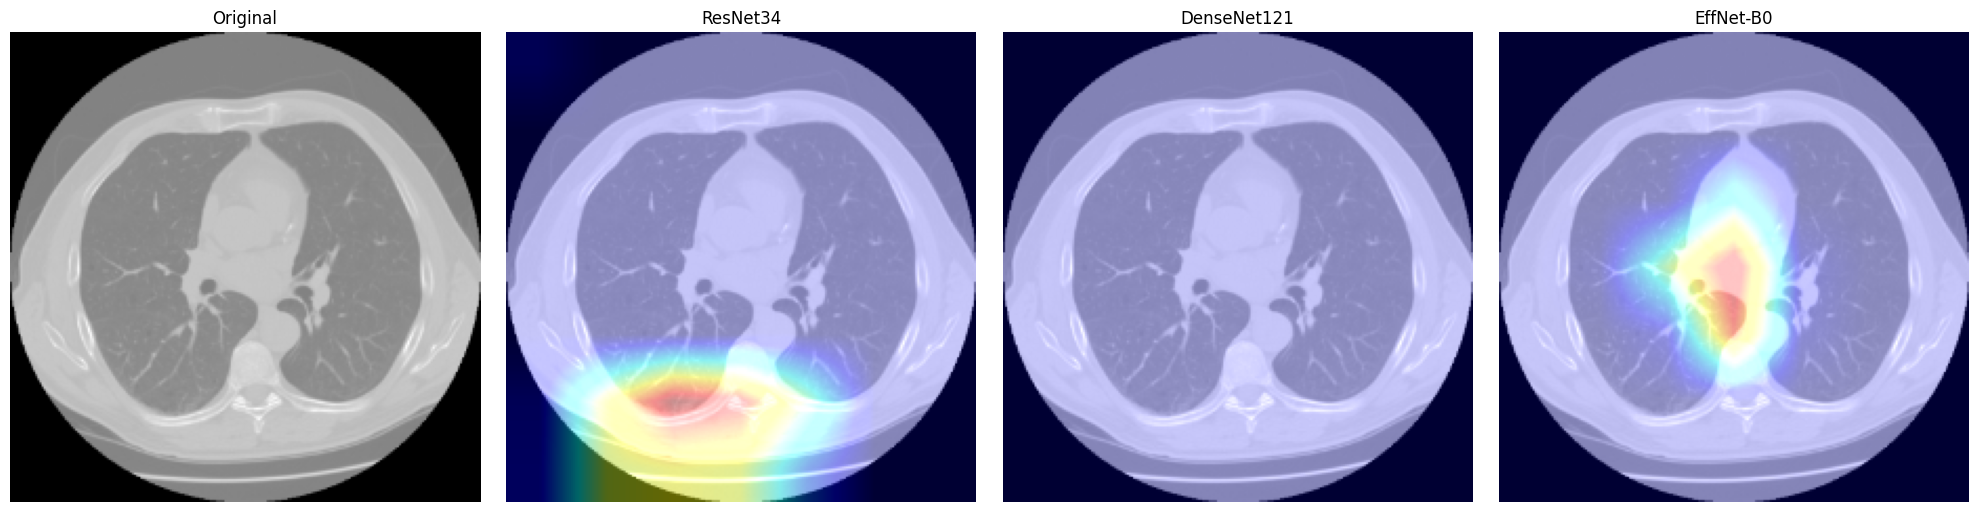

In [11]:
# Grad-CAM Utilities
import cv2
import matplotlib.pyplot as plt

def apply_gradcam(model, image_tensor, target_layer, device=DEVICE):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device).requires_grad_()

    activations, gradients = [], []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    f_hook = target_layer.register_forward_hook(forward_hook)
    b_hook = target_layer.register_backward_hook(backward_hook)

    output = model(image_tensor)
    pred = torch.sigmoid(output).item()
    output.backward()

    grads = gradients[0]
    acts = activations[0]
    pooled_grads = torch.mean(grads, dim=(2, 3), keepdim=True)
    weighted_acts = pooled_grads * acts
    cam = torch.sum(weighted_acts, dim=1).squeeze()

    cam = cam.cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam, (224, 224))

    f_hook.remove()
    b_hook.remove()

    return cam, pred

def show_gradcam_overlay(image_tensor, cam):
    img = image_tensor.squeeze().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]

    overlay = 0.4 * heatmap + np.repeat(img[:, :, None], 3, axis=2)
    overlay = np.clip(overlay, 0, 1)

    return overlay

# Sample Grad-CAM Execution (for 1 image)
for image, label, path in val_loader_with_paths:
    image = image[0]
    label = int(label[0])
    print("Label:", label, "Path:", path[0])
    break

cam_r, _ = apply_gradcam(resnet34_model, image, resnet34_model.layer4)
cam_d, _ = apply_gradcam(densenet_model, image, densenet_model.features.denseblock4)
cam_e, _ = apply_gradcam(effnet_model, image, effnet_model.features[-1])

original = image.squeeze().cpu().numpy()
original = (original - original.min()) / (original.max() - original.min() + 1e-8)
original = np.repeat(original[:, :, None], 3, axis=2)

overlay_r = show_gradcam_overlay(image, cam_r)
overlay_d = show_gradcam_overlay(image, cam_d)
overlay_e = show_gradcam_overlay(image, cam_e)

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(original)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(overlay_r)
plt.title('ResNet34')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(overlay_d)
plt.title('DenseNet121')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(overlay_e)
plt.title('EffNet-B0')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import json

# JSON 파일 열기
with open("ensemble_predictions.json") as f:
    data = json.load(f)

# label=1인 악성 샘플 중에서 확률 높은 순 정렬
top_malignant = sorted(
    [d for d in data if d["label"] == 1],
    key=lambda x: -x["ensemble_prob"]
)[:3]

# 경로 출력
for d in top_malignant:
    print(d["file"], d["ensemble_prob"])

/data1/lidc-idri/slices/LIDC-IDRI-0194/slice_078_5.npy 1.0
/data1/lidc-idri/slices/LIDC-IDRI-0332/slice_066_5.npy 1.0
/data1/lidc-idri/slices/LIDC-IDRI-0081/slice_083_5.npy 1.0


📌 Now showing: /data1/lidc-idri/slices/LIDC-IDRI-0194/slice_078_5.npy


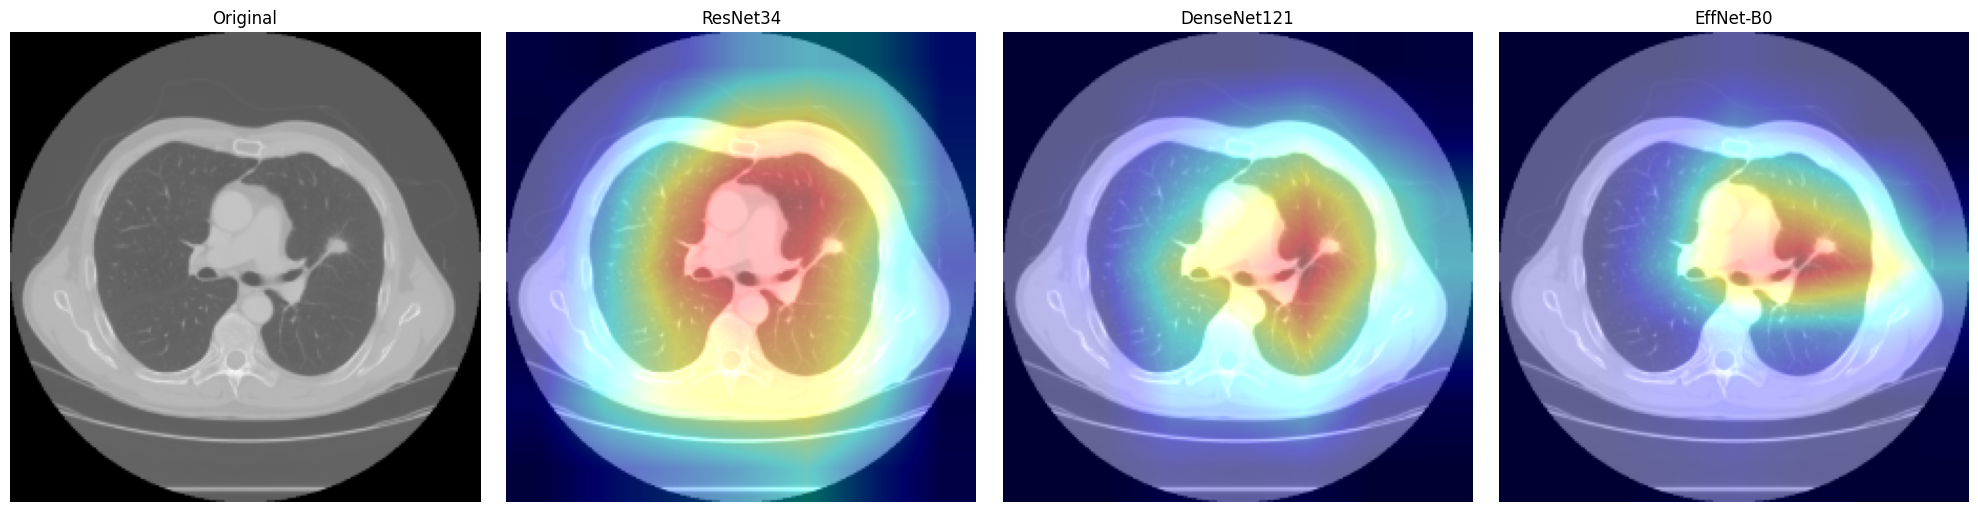

📌 Now showing: /data1/lidc-idri/slices/LIDC-IDRI-0332/slice_066_5.npy


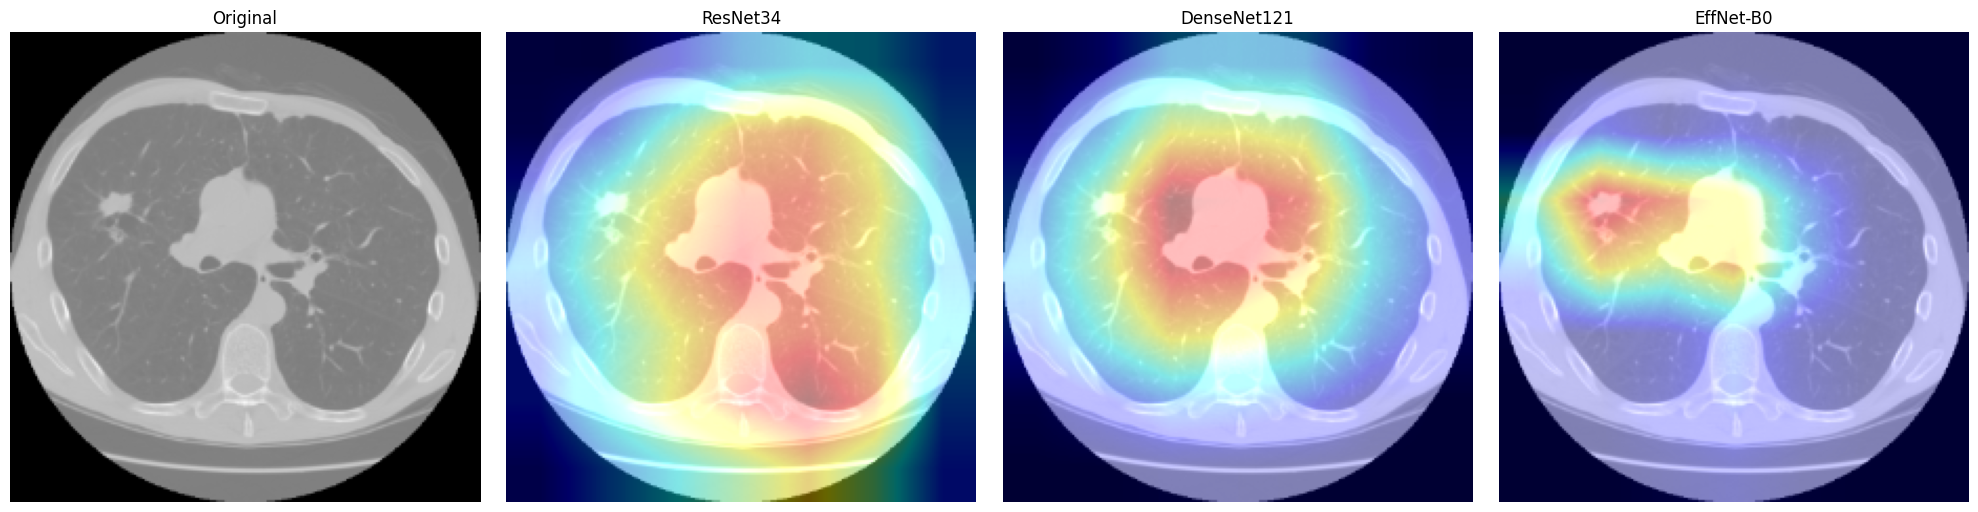

📌 Now showing: /data1/lidc-idri/slices/LIDC-IDRI-0081/slice_083_5.npy


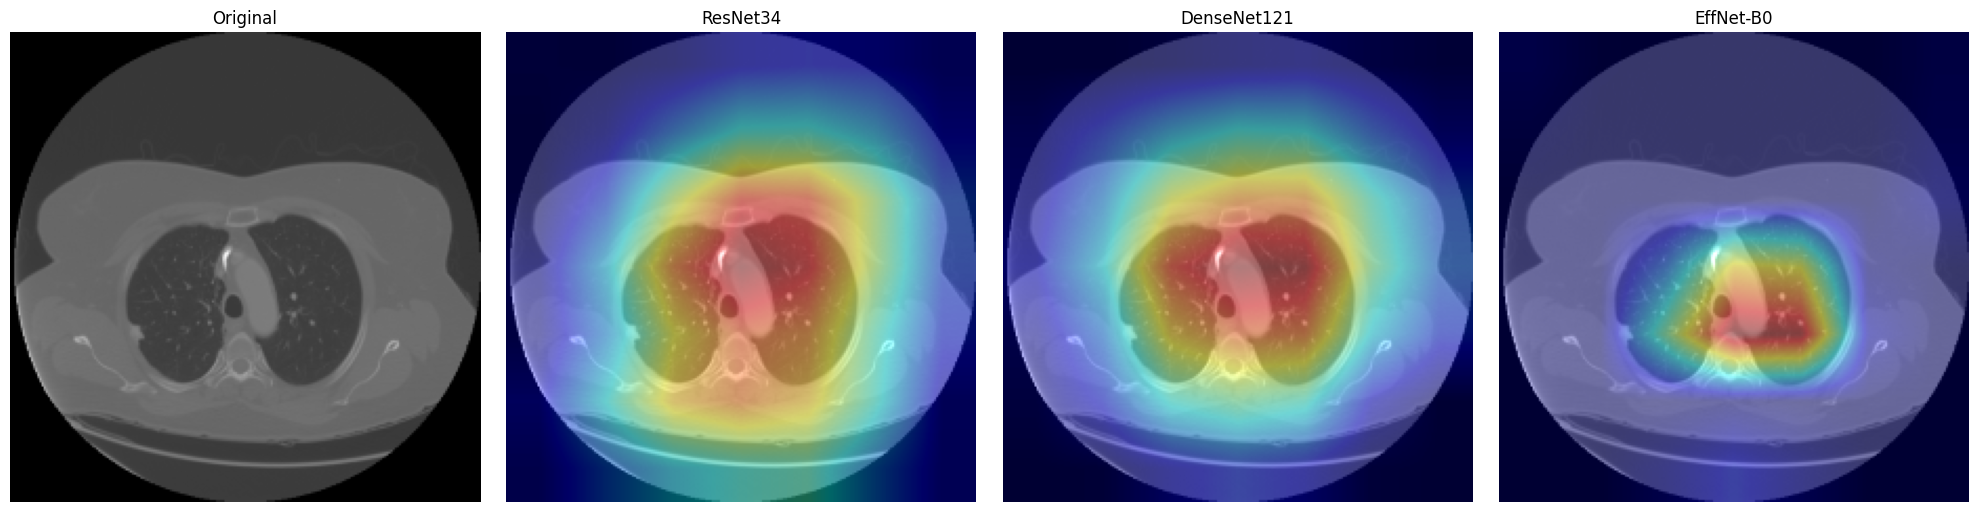

In [14]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

from torchvision.models import (
    resnet34 as resnet34_fn,
    densenet121 as densenet121_fn,
    efficientnet_b0 as efficientnet_b0_fn,
    ResNet34_Weights,
    DenseNet121_Weights,
    EfficientNet_B0_Weights
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 모델 로드
def load_models():
    m1 = resnet34_fn(weights=ResNet34_Weights.IMAGENET1K_V1)
    m1.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m1.fc = nn.Linear(m1.fc.in_features, 1)
    m1.load_state_dict(torch.load("best_model_resnet34.pth"))
    m1.to(DEVICE).eval()

    m2 = densenet121_fn(weights=DenseNet121_Weights.IMAGENET1K_V1)
    m2.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m2.classifier = nn.Linear(m2.classifier.in_features, 1)
    m2.load_state_dict(torch.load("best_model_densenet121.pth"))
    m2.to(DEVICE).eval()

    m3 = efficientnet_b0_fn(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    m3.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    m3.classifier[1] = nn.Linear(m3.classifier[1].in_features, 1)
    m3.load_state_dict(torch.load("best_model_efficientnet_b0.pth"))
    m3.to(DEVICE).eval()

    return m1, m2, m3

resnet34_model, densenet_model, effnet_model = load_models()

# ✅ Grad-CAM 추출 함수
def apply_gradcam(model, image_tensor, target_layer):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(DEVICE).requires_grad_()

    activations, gradients = [], []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    f_hook = target_layer.register_forward_hook(forward_hook)
    b_hook = target_layer.register_backward_hook(backward_hook)

    output = model(image_tensor)
    output.backward()

    grads = gradients[0]
    acts = activations[0]
    pooled_grads = torch.mean(grads, dim=(2, 3), keepdim=True)
    weighted_acts = pooled_grads * acts
    cam = torch.sum(weighted_acts, dim=1).squeeze()

    cam = cam.cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam, (224, 224))

    f_hook.remove()
    b_hook.remove()

    return cam

# ✅ 시각화 함수
def show_all_gradcams(npy_path):
    img = np.load(npy_path).astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img_tensor = torch.tensor(img).unsqueeze(0)
    img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

    cam_r = apply_gradcam(resnet34_model, img_tensor, resnet34_model.layer4)
    cam_d = apply_gradcam(densenet_model, img_tensor, densenet_model.features.denseblock4)
    cam_e = apply_gradcam(effnet_model, img_tensor, effnet_model.features[-1])

    original = img_tensor.squeeze().cpu().numpy()
    original = np.repeat(original[:, :, None], 3, axis=2)

    def overlay(cam):
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        heatmap = heatmap[..., ::-1]
        return np.clip(0.4 * heatmap + original, 0, 1)

    overlays = [original, overlay(cam_r), overlay(cam_d), overlay(cam_e)]

    titles = ["Original", "ResNet34", "DenseNet121", "EffNet-B0"]
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for ax, img, title in zip(axes, overlays, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ 상위 3개 악성 샘플 경로에 대해 실행
top3_paths = [
    "/data1/lidc-idri/slices/LIDC-IDRI-0194/slice_078_5.npy",
    "/data1/lidc-idri/slices/LIDC-IDRI-0332/slice_066_5.npy",
    "/data1/lidc-idri/slices/LIDC-IDRI-0081/slice_083_5.npy"
]

for path in top3_paths:
    print(f"📌 Now showing: {path}")
    show_all_gradcams(path)

In [15]:
import json

with open("ensemble_predictions.json") as f:
    data = json.load(f)

# 악성 확률 높은 순 상위 3개
top3_malignant = sorted(
    [d for d in data if d["label"] == 1],
    key=lambda x: -x["ensemble_prob"]
)[:3]

# 양성 확률 낮은 순 하위 3개
bottom3_benign = sorted(
    [d for d in data if d["label"] == 0],
    key=lambda x: x["ensemble_prob"]
)[:3]

for d in top3_malignant + bottom3_benign:
    print(f"{d['file']} (label={d['label']}, prob={d['ensemble_prob']:.4f})")

/data1/lidc-idri/slices/LIDC-IDRI-0194/slice_078_5.npy (label=1, prob=1.0000)
/data1/lidc-idri/slices/LIDC-IDRI-0332/slice_066_5.npy (label=1, prob=1.0000)
/data1/lidc-idri/slices/LIDC-IDRI-0081/slice_083_5.npy (label=1, prob=1.0000)
/data1/lidc-idri/slices/LIDC-IDRI-0118/slice_028_1.npy (label=0, prob=0.0000)
/data1/lidc-idri/slices/LIDC-IDRI-0426/slice_047_1.npy (label=0, prob=0.0000)
/data1/lidc-idri/slices/LIDC-IDRI-0379/slice_063_2.npy (label=0, prob=0.0000)


📌 /data1/lidc-idri/slices/LIDC-IDRI-0194/slice_078_5.npy


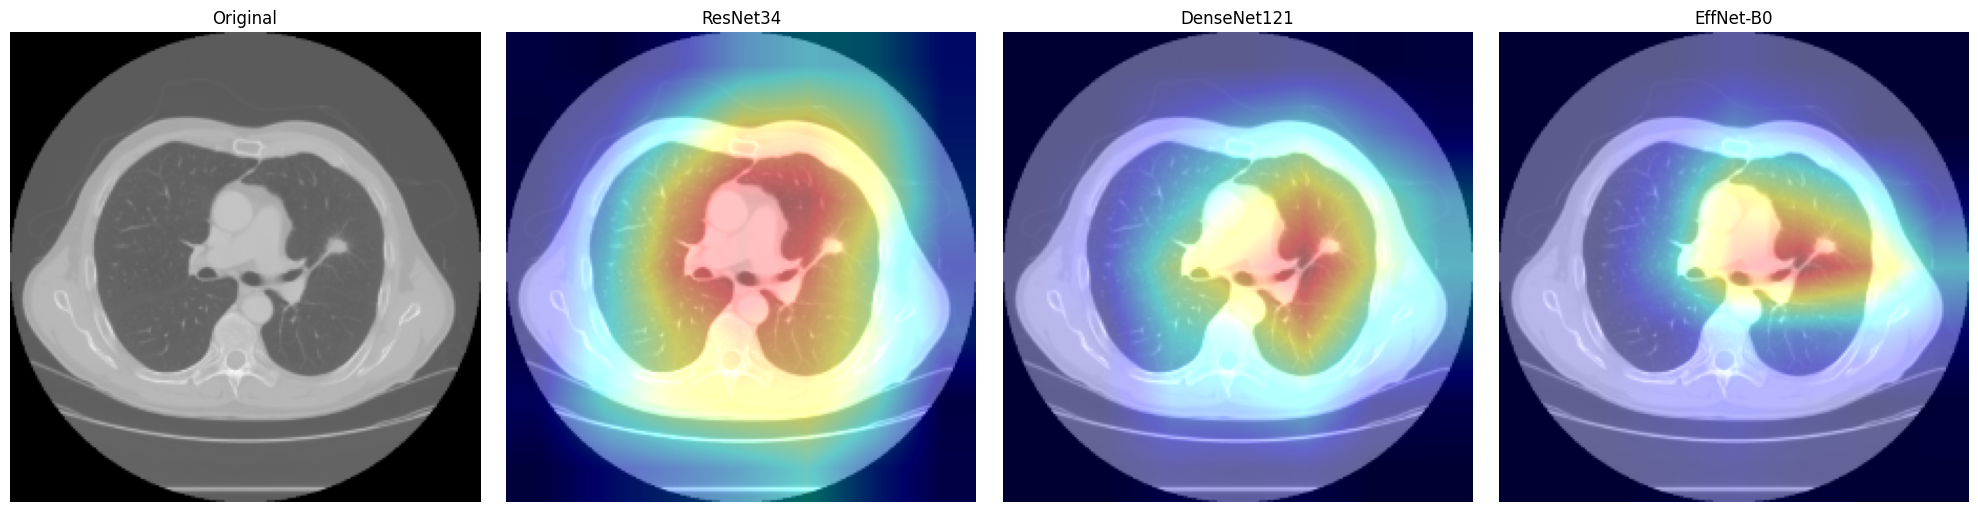

📌 /data1/lidc-idri/slices/LIDC-IDRI-0332/slice_066_5.npy


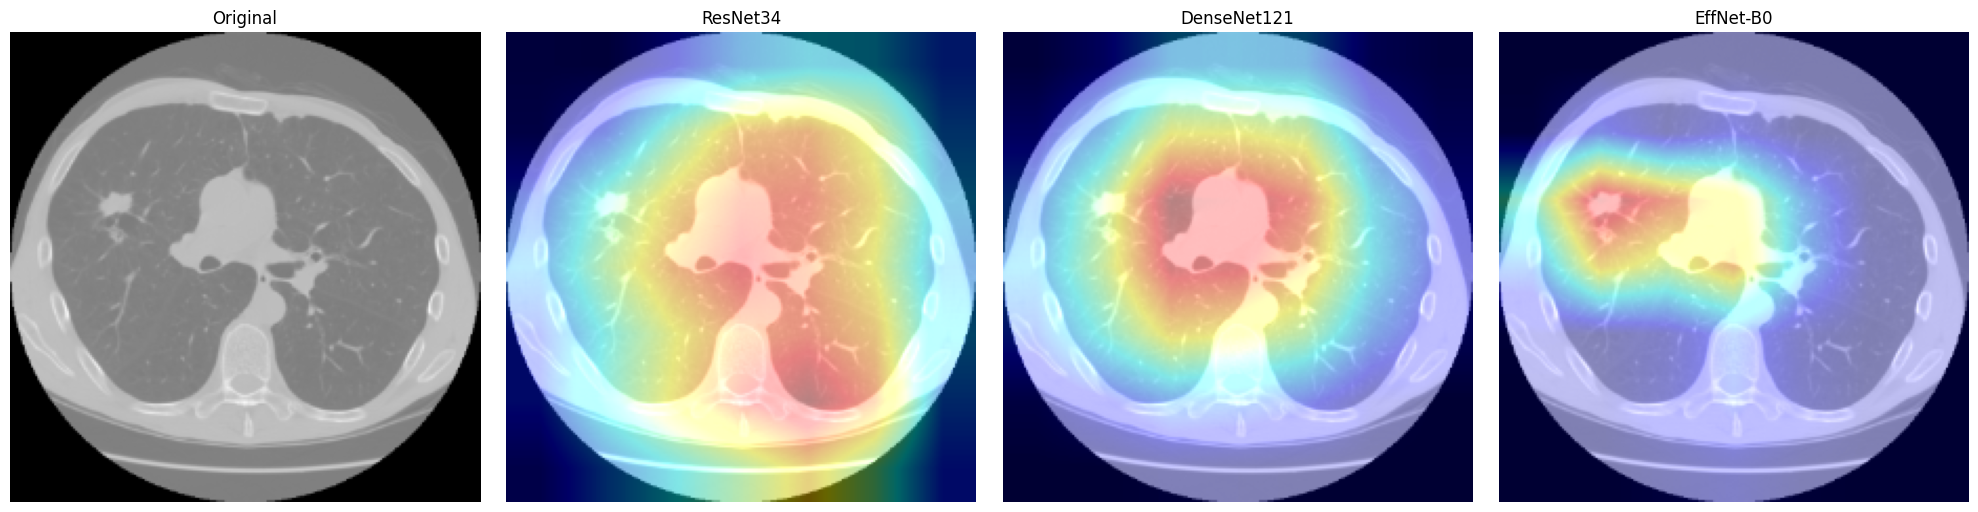

📌 /data1/lidc-idri/slices/LIDC-IDRI-0081/slice_083_5.npy


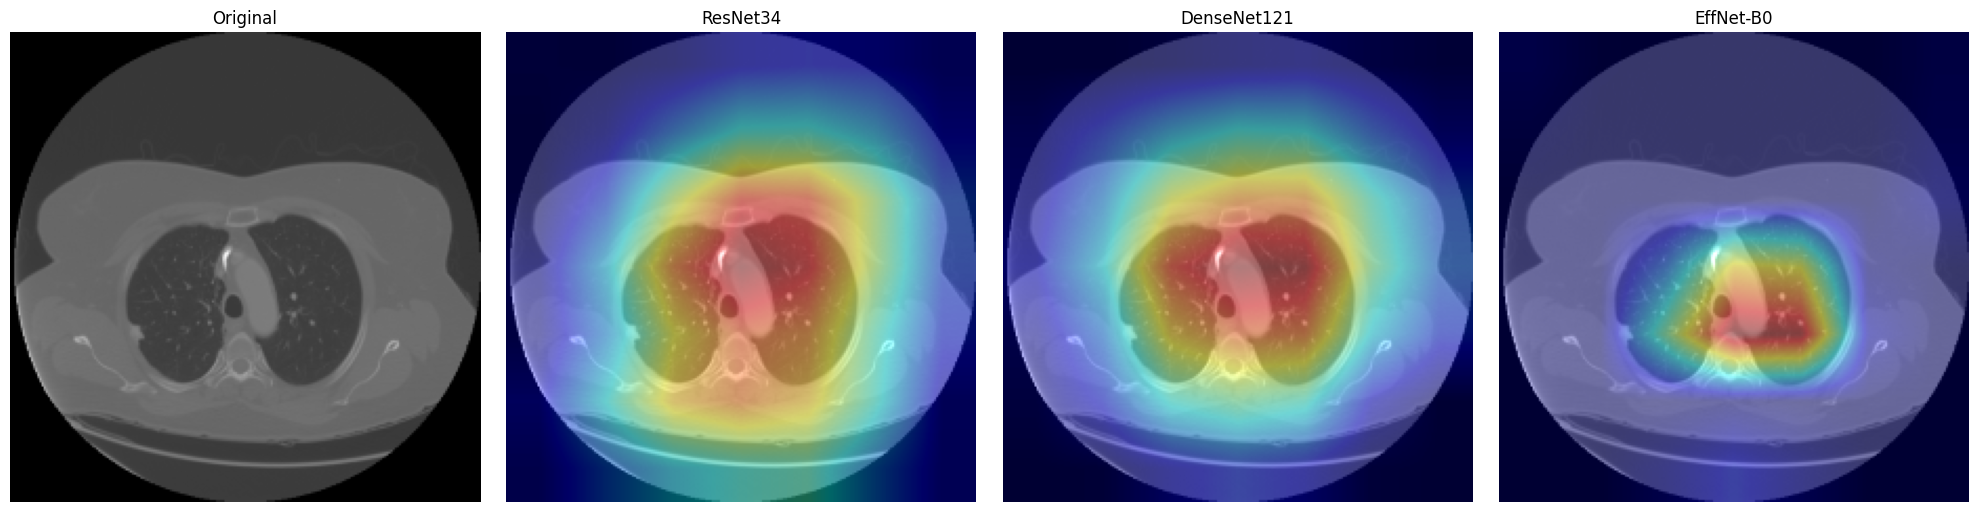

📌 /data1/lidc-idri/slices/LIDC-IDRI-0118/slice_028_1.npy


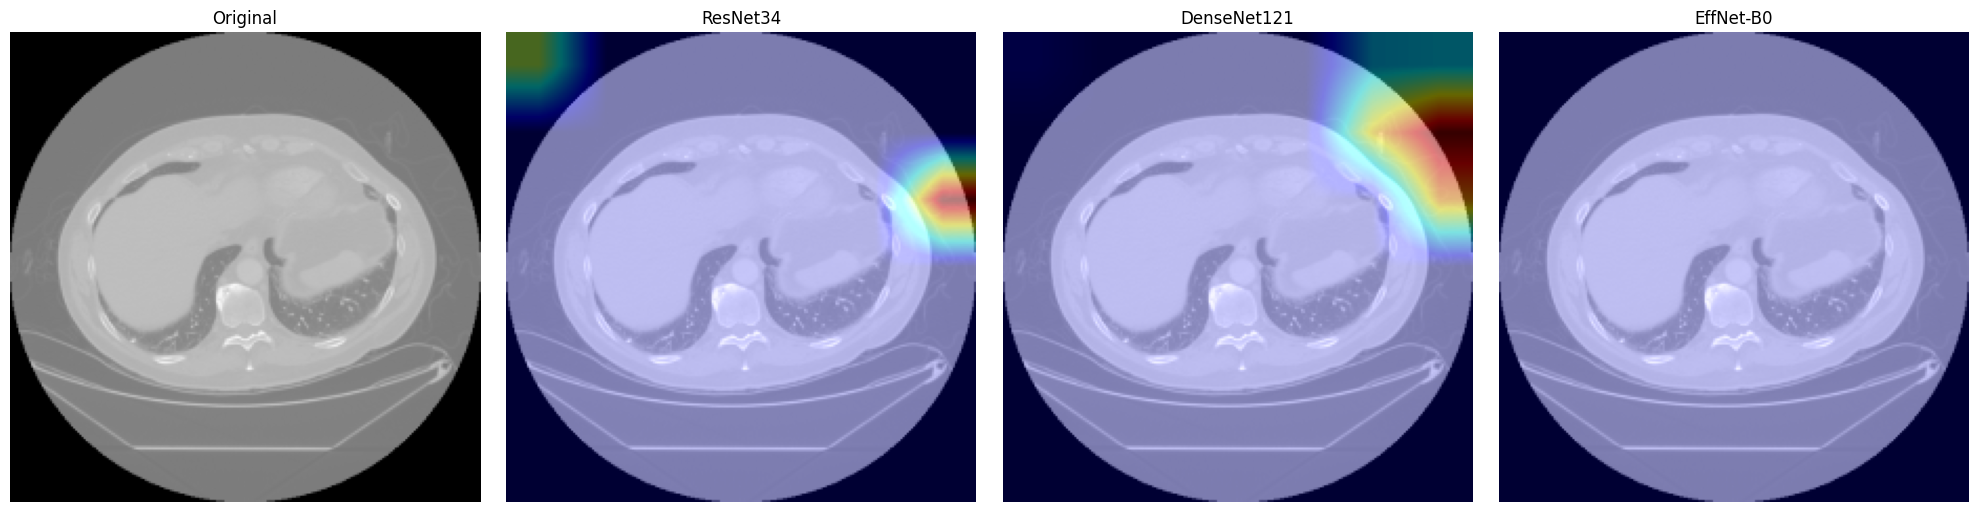

📌 /data1/lidc-idri/slices/LIDC-IDRI-0426/slice_047_1.npy


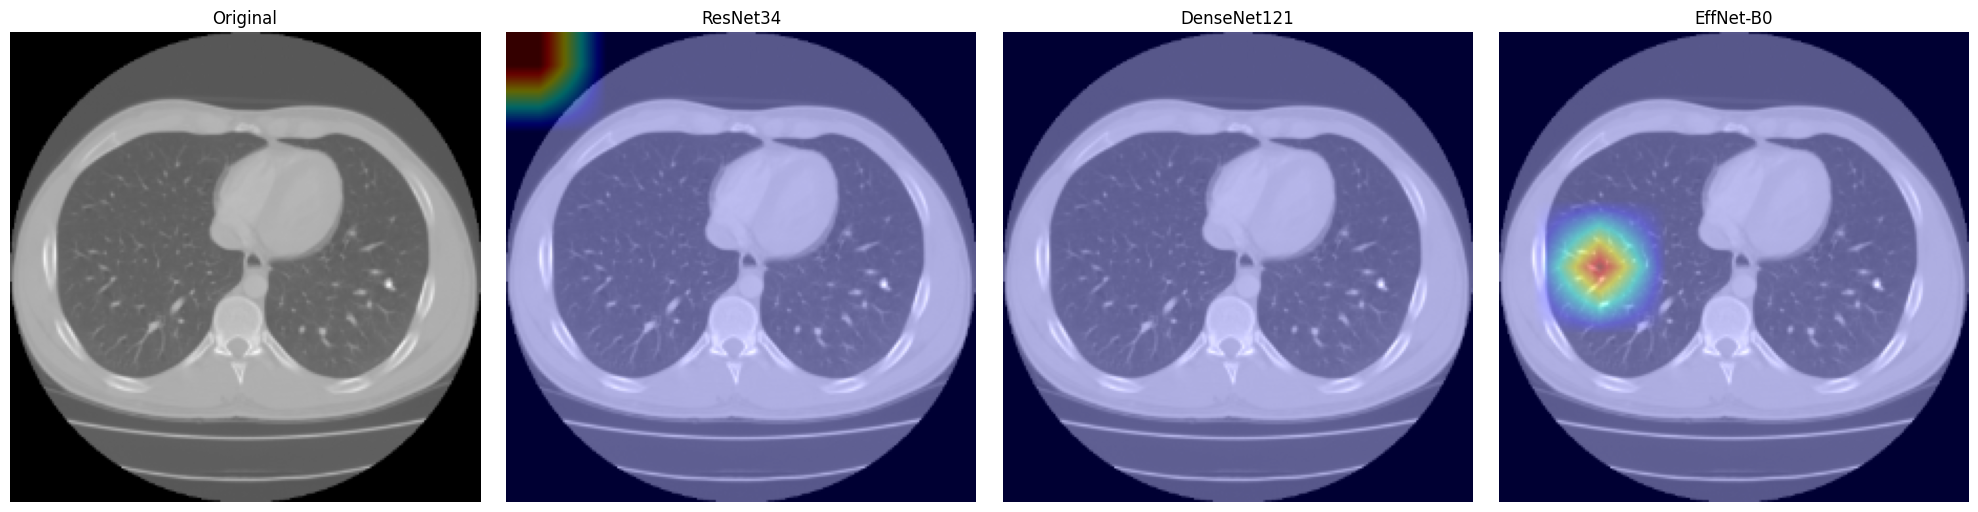

📌 /data1/lidc-idri/slices/LIDC-IDRI-0379/slice_063_2.npy


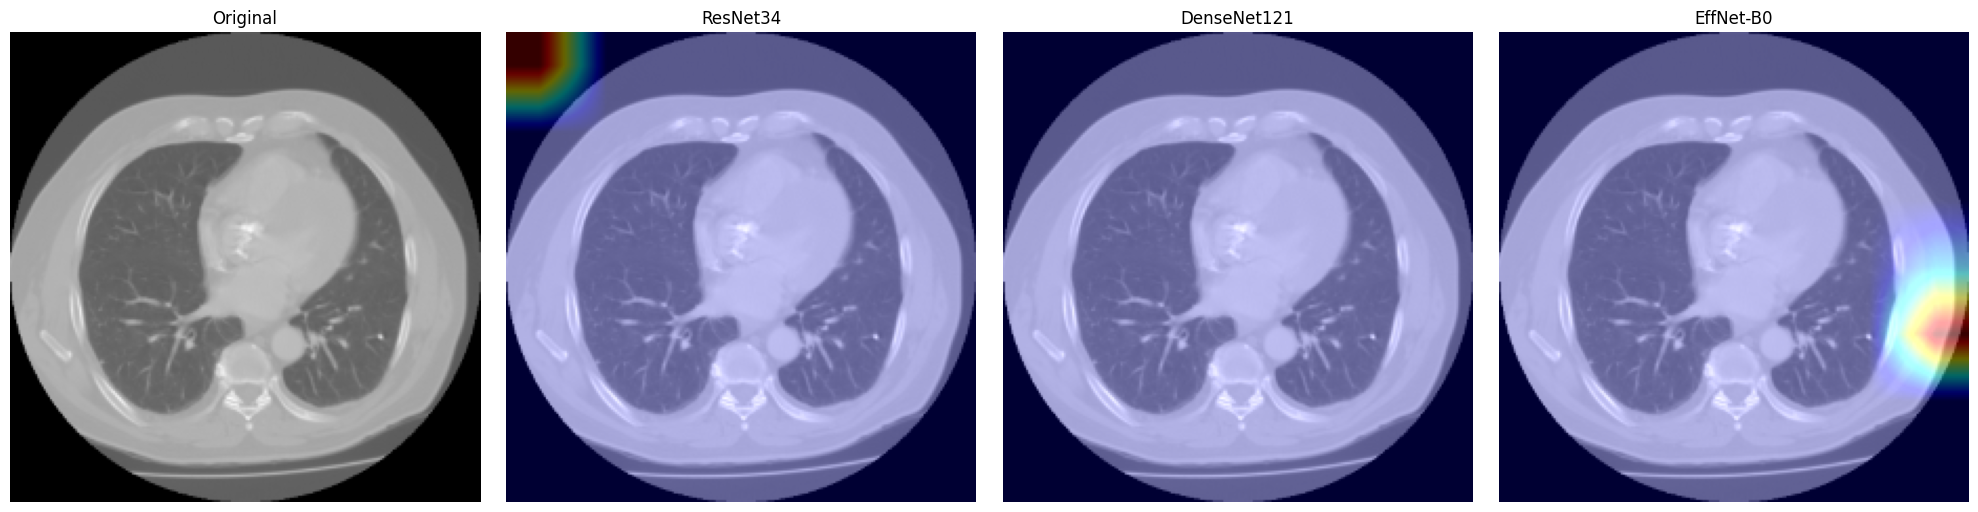

In [16]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

from torchvision.models import (
    resnet34 as resnet34_fn,
    densenet121 as densenet121_fn,
    efficientnet_b0 as efficientnet_b0_fn,
    ResNet34_Weights,
    DenseNet121_Weights,
    EfficientNet_B0_Weights
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_models():
    m1 = resnet34_fn(weights=ResNet34_Weights.IMAGENET1K_V1)
    m1.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m1.fc = nn.Linear(m1.fc.in_features, 1)
    m1.load_state_dict(torch.load("best_model_resnet34.pth"))
    m1.to(DEVICE).eval()

    m2 = densenet121_fn(weights=DenseNet121_Weights.IMAGENET1K_V1)
    m2.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m2.classifier = nn.Linear(m2.classifier.in_features, 1)
    m2.load_state_dict(torch.load("best_model_densenet121.pth"))
    m2.to(DEVICE).eval()

    m3 = efficientnet_b0_fn(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    m3.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    m3.classifier[1] = nn.Linear(m3.classifier[1].in_features, 1)
    m3.load_state_dict(torch.load("best_model_efficientnet_b0.pth"))
    m3.to(DEVICE).eval()

    return m1, m2, m3

resnet34_model, densenet_model, effnet_model = load_models()

def apply_gradcam(model, image_tensor, target_layer):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(DEVICE).requires_grad_()
    activations, gradients = [], []

    def forward_hook(module, input, output): activations.append(output)
    def backward_hook(module, grad_in, grad_out): gradients.append(grad_out[0])

    f_hook = target_layer.register_forward_hook(forward_hook)
    b_hook = target_layer.register_backward_hook(backward_hook)

    output = model(image_tensor)
    output.backward()

    grads = gradients[0]
    acts = activations[0]
    pooled_grads = torch.mean(grads, dim=(2, 3), keepdim=True)
    weighted_acts = pooled_grads * acts
    cam = torch.sum(weighted_acts, dim=1).squeeze().cpu().detach().numpy()

    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam, (224, 224))

    f_hook.remove(); b_hook.remove()
    return cam

def show_all_gradcams(npy_path):
    img = np.load(npy_path).astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img_tensor = torch.tensor(img).unsqueeze(0)
    img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

    cam_r = apply_gradcam(resnet34_model, img_tensor, resnet34_model.layer4)
    cam_d = apply_gradcam(densenet_model, img_tensor, densenet_model.features.denseblock4)
    cam_e = apply_gradcam(effnet_model, img_tensor, effnet_model.features[-1])

    original = img_tensor.squeeze().cpu().numpy()
    original = np.repeat(original[:, :, None], 3, axis=2)

    def overlay(cam):
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        heatmap = heatmap[..., ::-1]
        return np.clip(0.4 * heatmap + original, 0, 1)

    overlays = [original, overlay(cam_r), overlay(cam_d), overlay(cam_e)]
    titles = ["Original", "ResNet34", "DenseNet121", "EffNet-B0"]
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for ax, img, title in zip(axes, overlays, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 🎯 여기에 6장 넣어서 실행
paths = [
    "/data1/lidc-idri/slices/LIDC-IDRI-0194/slice_078_5.npy",
    "/data1/lidc-idri/slices/LIDC-IDRI-0332/slice_066_5.npy",
    "/data1/lidc-idri/slices/LIDC-IDRI-0081/slice_083_5.npy",
    "/data1/lidc-idri/slices/LIDC-IDRI-0118/slice_028_1.npy",
    "/data1/lidc-idri/slices/LIDC-IDRI-0426/slice_047_1.npy",
    "/data1/lidc-idri/slices/LIDC-IDRI-0379/slice_063_2.npy"
]

for path in paths:
    print(f"📌 {path}")
    show_all_gradcams(path)

In [18]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

# 저장 디렉토리 생성
# 저장 디렉토리 변경
save_dir = "./gradcam_outputs"  # 현재 작업 디렉토리에 저장
os.makedirs(save_dir, exist_ok=True)

# Grad-CAM 시각화 + 저장 함수
def save_all_gradcams(npy_path, save_path):
    img = np.load(npy_path).astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img_tensor = torch.tensor(img).unsqueeze(0)
    img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

    cam_r = apply_gradcam(resnet34_model, img_tensor, resnet34_model.layer4)
    cam_d = apply_gradcam(densenet_model, img_tensor, densenet_model.features.denseblock4)
    cam_e = apply_gradcam(effnet_model, img_tensor, effnet_model.features[-1])

    original = img_tensor.squeeze().cpu().numpy()
    original = np.repeat(original[:, :, None], 3, axis=2)

    def overlay(cam):
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        heatmap = heatmap[..., ::-1]
        return np.clip(0.4 * heatmap + original, 0, 1)

    overlays = [original, overlay(cam_r), overlay(cam_d), overlay(cam_e)]
    titles = ["Original", "ResNet34", "DenseNet121", "EffNet-B0"]
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for ax, img, title in zip(axes, overlays, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    fig.savefig(save_path)
    plt.close(fig)

# 저장 대상 파일 경로
gradcam_paths = [
    "/data1/lidc-idri/slices/LIDC-IDRI-0194/slice_078_5.npy",
    "/data1/lidc-idri/slices/LIDC-IDRI-0332/slice_066_5.npy",
    "/data1/lidc-idri/slices/LIDC-IDRI-0081/slice_083_5.npy",
    "/data1/lidc-idri/slices/LIDC-IDRI-0118/slice_028_1.npy",
    "/data1/lidc-idri/slices/LIDC-IDRI-0426/slice_047_1.npy",
    "/data1/lidc-idri/slices/LIDC-IDRI-0379/slice_063_2.npy"
]

# 저장 루프
for idx, path in enumerate(gradcam_paths):
    label = "malignant" if idx < 3 else "benign"
    save_path = os.path.join(save_dir, f"gradcam_{label}_{idx%3+1}.png")
    save_all_gradcams(path, save_path)

# 저장 확인
print("✅ 저장 완료!")
print("\n📂 저장된 파일:")
for f in os.listdir(save_dir):
    print("•", f)

✅ 저장 완료!

📂 저장된 파일:
• gradcam_benign_3.png
• gradcam_malignant_1.png
• gradcam_benign_2.png
• gradcam_malignant_2.png
• gradcam_malignant_3.png
• gradcam_benign_1.png
